Projekat 2

Filip Nikolić   
Jovan Dimitrijević

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

Sredjivanje dataset-a

In [ ]:
# Load the CSV file
df = pd.read_csv('books_original.csv')

# Remove the last 32 columns
df = df.iloc[:, :-32]

# Save the modified DataFrame to a new CSV file
df.to_csv('books.csv', index=False)

Priprema podataka za treniranje modela

In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Function to convert time string to minutes past midnight
def time_to_minutes(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes

# Load your dataset
df = pd.read_csv('books.csv')

# Convert the 'time' column to datetime objects and then format to 24-hour time
df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%H:%M')

# Apply the conversion to the 'Time' column
df['Time'] = df['Time'].apply(time_to_minutes)

label_encoder = LabelEncoder()
df['Product-Name'] = label_encoder.fit_transform(df['Product-Name'])
df['Item-Status'] = label_encoder.fit_transform(df['Item-Status'])
df['Currency'] = label_encoder.fit_transform(df['Currency'])
df['Ship-City'] = label_encoder.fit_transform(df['Ship-City'])
df['Ship-State'] = label_encoder.fit_transform(df['Ship-State'])
df['Category'] = label_encoder.fit_transform(df['Category'])
df['Author'] = label_encoder.fit_transform(df['Author'])
df['Publication'] = label_encoder.fit_transform(df['Publication'])

# Drop the columns you don't want to use for clustering
df = df.drop(['ID', 'Purchase-date', 'Quarter', 'Date', 'Customer ID', 'Gender.2', 'Item-Status', 'Currency'], axis=1)

df.to_csv('books_prepared.csv', index=False)

Odredjivanje lakta krive kod K-means modela

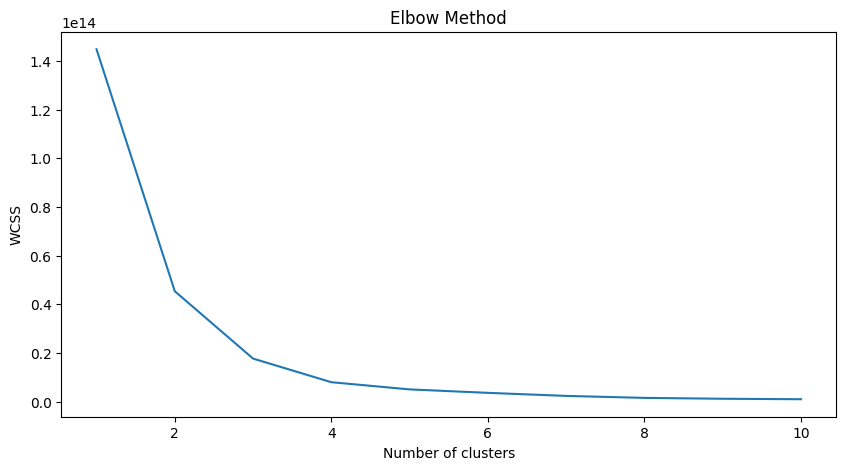

In [10]:
df = pd.read_csv('books_prepared.csv')

# Elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe 'The elbow'
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # within cluster sum of squares
plt.show()

Klasterizacija koriscenjem K-means modela

In [11]:
# Choose the number of clusters
n_clusters = int(input("Enter the optimal number of clusters: "))

# For example, using KMeans
kmeans = KMeans(n_clusters=n_clusters)  # Adjust the number of clusters as needed

# Apply clustering algorithm on the selected columns
clusters = kmeans.fit_predict(df)

# You can add the cluster labels back to your original DataFrame if needed
df['cluster'] = clusters

# Save the DataFrame with cluster labels
df.to_csv('books_clustered-kmeans.csv', index=False)

# Silhouette Score
silhouette_avg = silhouette_score(df, clusters)
print("Silhouette Score: ", silhouette_avg)

/Users/filipnikolic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score:  0.6770948208608171


Odredjivanje, normalizacija i vizuelizacija centroida K-means modela


Normalized Centroids:
        Time       Qtr      Year     Month    Date.1  Special Day  \
0  0.295174  0.202485  0.512367  0.157113  1.000000     0.315933   
1  0.873601  1.000000  0.056993  1.000000  0.931852     0.673285   
2  0.154385  0.322875  1.000000  0.368457  0.468020     0.782567   
3  0.826963  0.501611  0.000000  0.517441  0.000000     0.657207   
4  1.000000  0.572745  0.428130  0.620930  0.348358     0.000000   
5  0.000000  0.000000  0.433075  0.000000  0.738645     1.000000   
6  0.685173  0.561640  0.307289  0.541900  0.545531     0.960203   

   Online Sale Offers        Day   Weekend   Morning  ...  Ship-City  \
0             0.600136  0.000000  0.061981  0.000000  ...   0.946228   
1             0.000000  0.365327  0.766749  0.527162  ...   0.379594   
2             1.000000  0.422229  0.000000  1.000000  ...   0.000000   
3             0.233987  0.980677  1.000000  0.774817  ...   0.881628   
4             0.474712  1.000000  0.631742  0.866646  ...   1.000000   

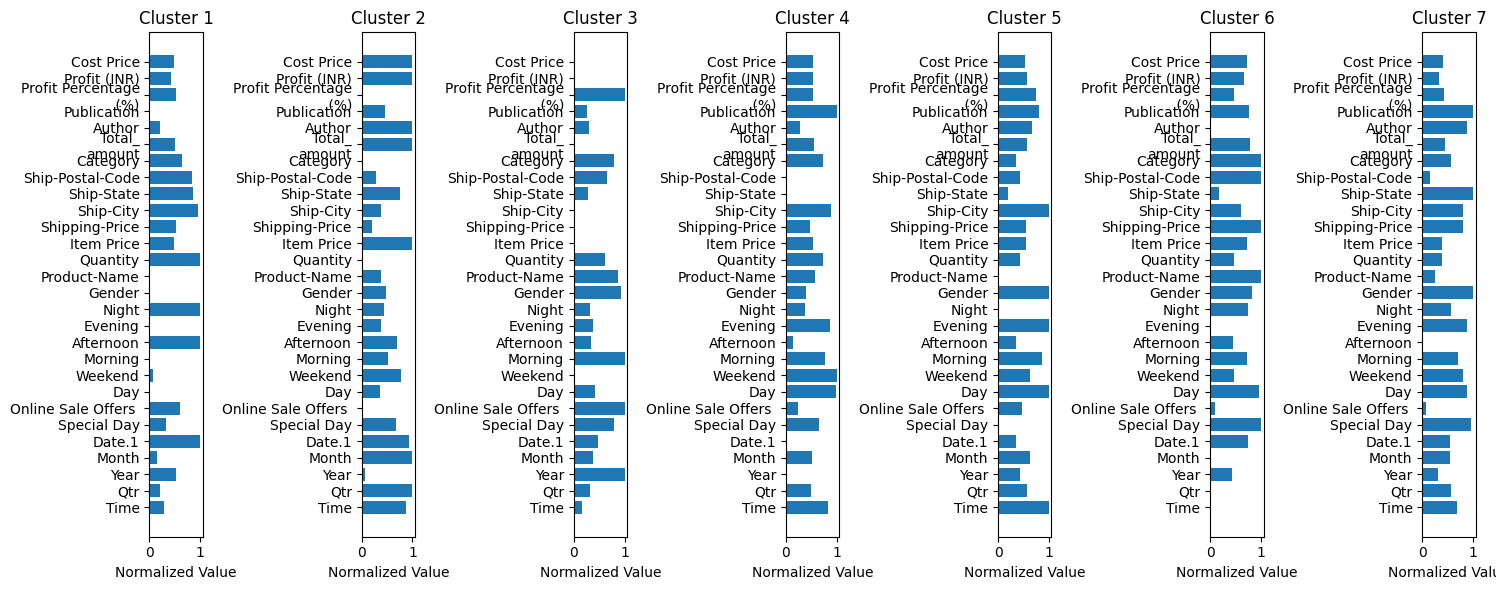

In [13]:
# Analyzing Cluster Centroids for Feature Importance
centroids = kmeans.cluster_centers_

# Normalize the centroids for better interpretation
centroids_normalized = centroids - centroids.min(axis=0)
centroids_normalized /= centroids_normalized.max(axis=0)

# Display the normalized centroids to understand feature values characterizing each cluster
centroids_df = pd.DataFrame(centroids_normalized, columns=df.columns[:-1])
print("\nNormalized Centroids:\n", centroids_df)

# Visualization of Normalized Centroids
plt.figure(figsize=(15, 6))
n_clusters = centroids_df.shape[0]
n_features = centroids_df.shape[1]

# Create a bar plot for each cluster
for i in range(n_clusters):
    plt.subplot(1, n_clusters, i+1)
    plt.barh(np.arange(n_features), centroids_df.iloc[i], align='center')
    plt.yticks(np.arange(n_features), centroids_df.columns)
    plt.xlabel('Normalized Value')
    plt.title('Cluster ' + str(i+1))

plt.tight_layout()
plt.show()

Odredjivanje najblizih suseda

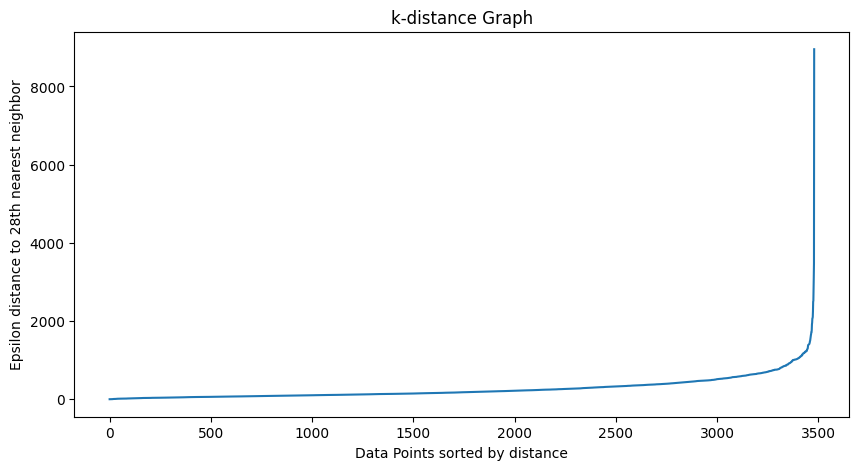

In [14]:
df = pd.read_csv('books_prepared.csv')

# Compute the nearest neighbors
nearest_neighbors = NearestNeighbors(n_neighbors=28)
neighbors = nearest_neighbors.fit(df)
distances, indices = neighbors.kneighbors(df)

# Sort distances
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon distance to 28th nearest neighbor')
plt.show()

Klasterizacija koriscenjem DBSCAN modela

In [15]:
# DBSCAN
dbscan = DBSCAN(eps=2000, min_samples=5)  # Adjust eps and min_samples as needed
dbscan_clusters = dbscan.fit_predict(df)

df['cluster'] = dbscan_clusters
df.to_csv('books_clustered-dbscan.csv', index=False)

# Compute Silhouette Score (if applicable)
silhouette_avg_dbscan = silhouette_score(df, dbscan_clusters)
print("Silhouette Score for DBSCAN: ", silhouette_avg_dbscan)

Silhouette Score for DBSCAN:  0.7238712122669981


Odredjivanje i vizuelizacija distribucije ficera po klasterima

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

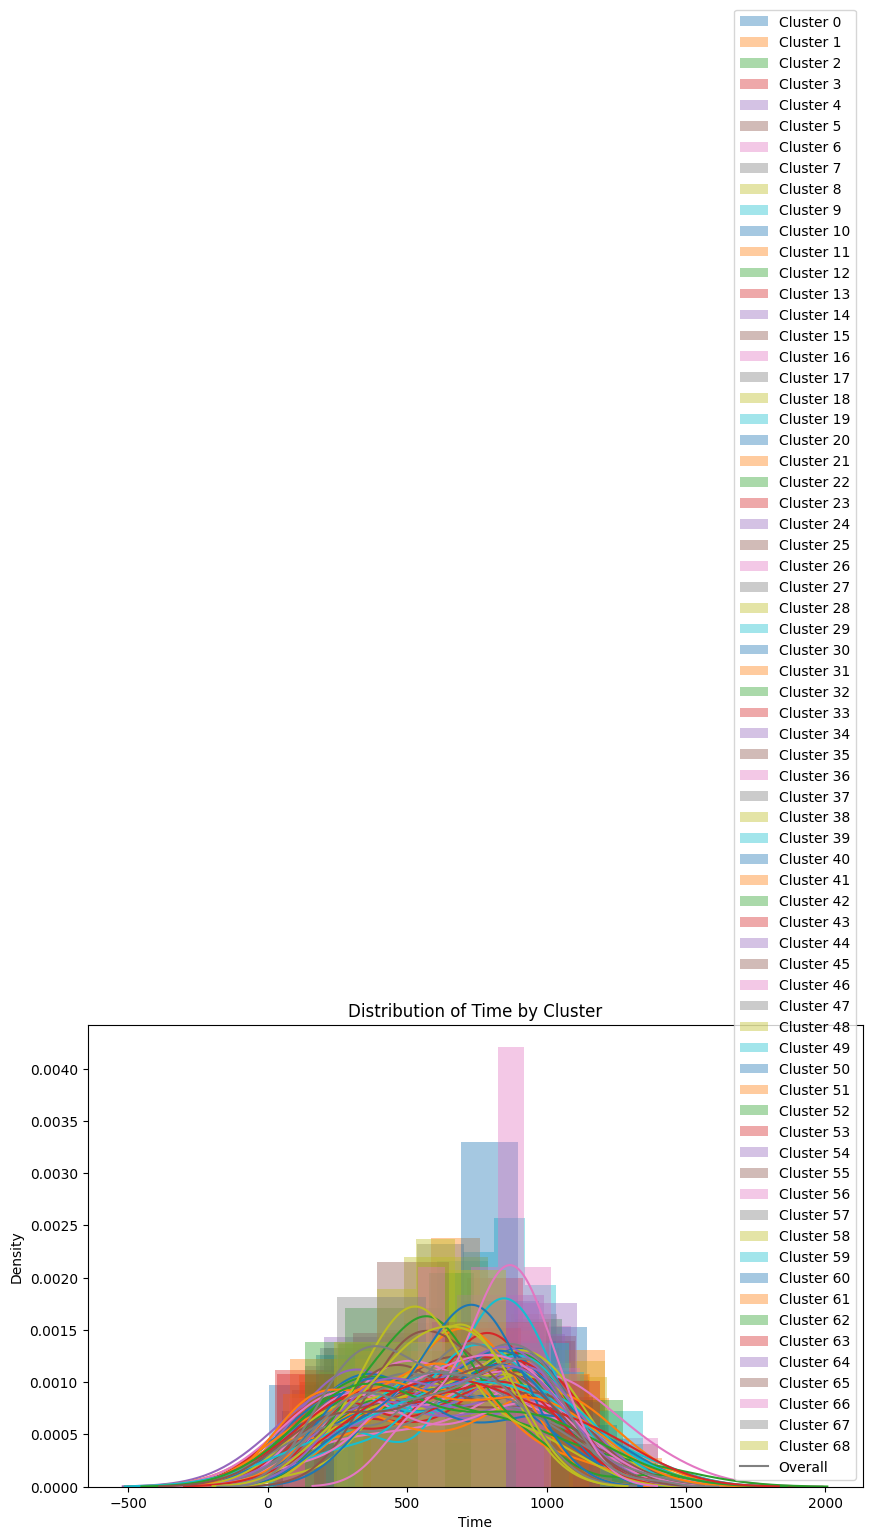

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

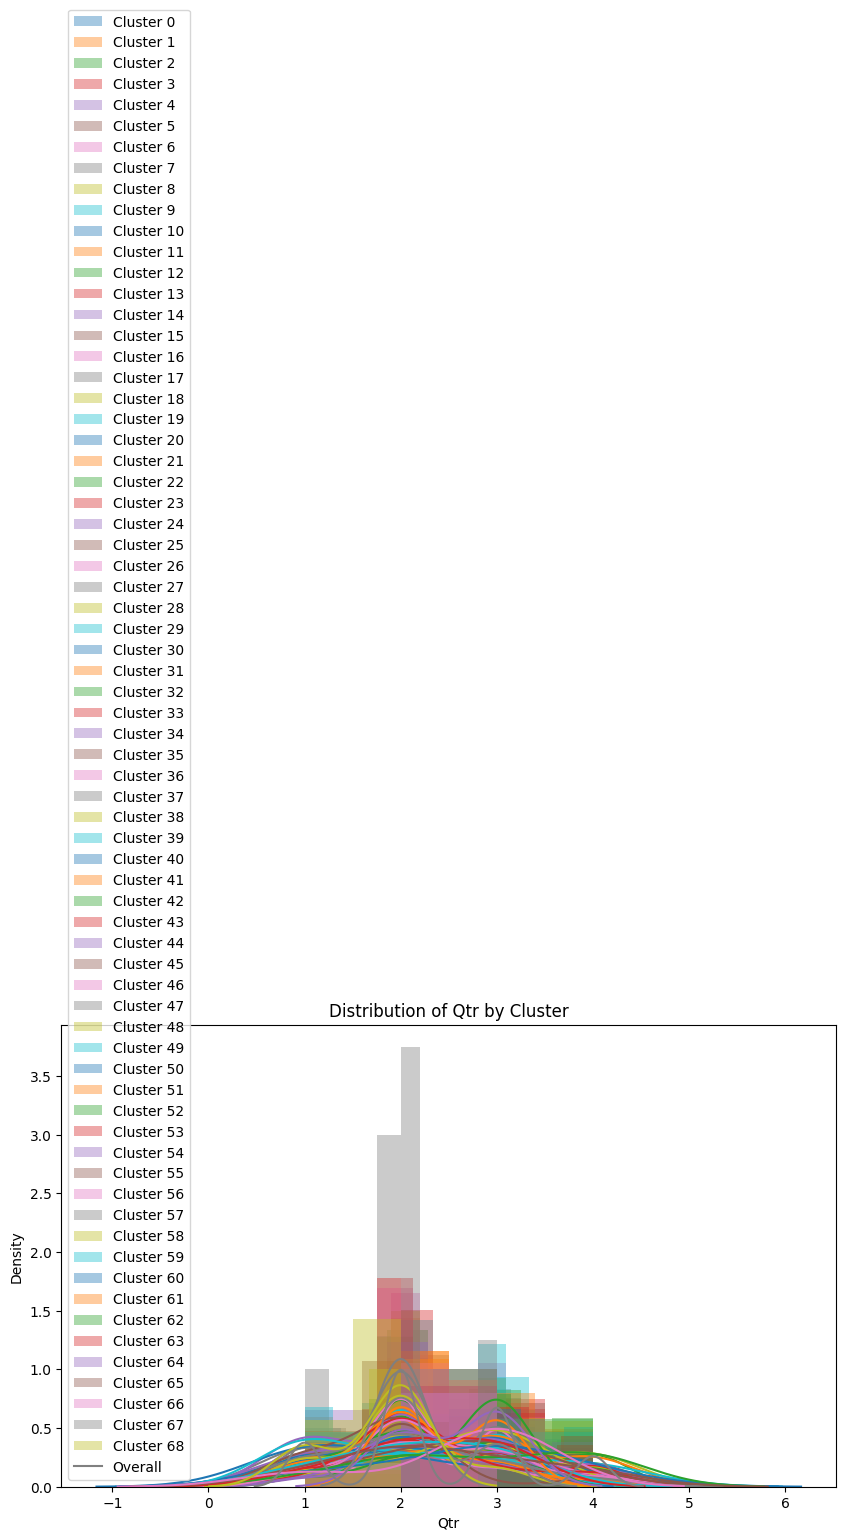

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

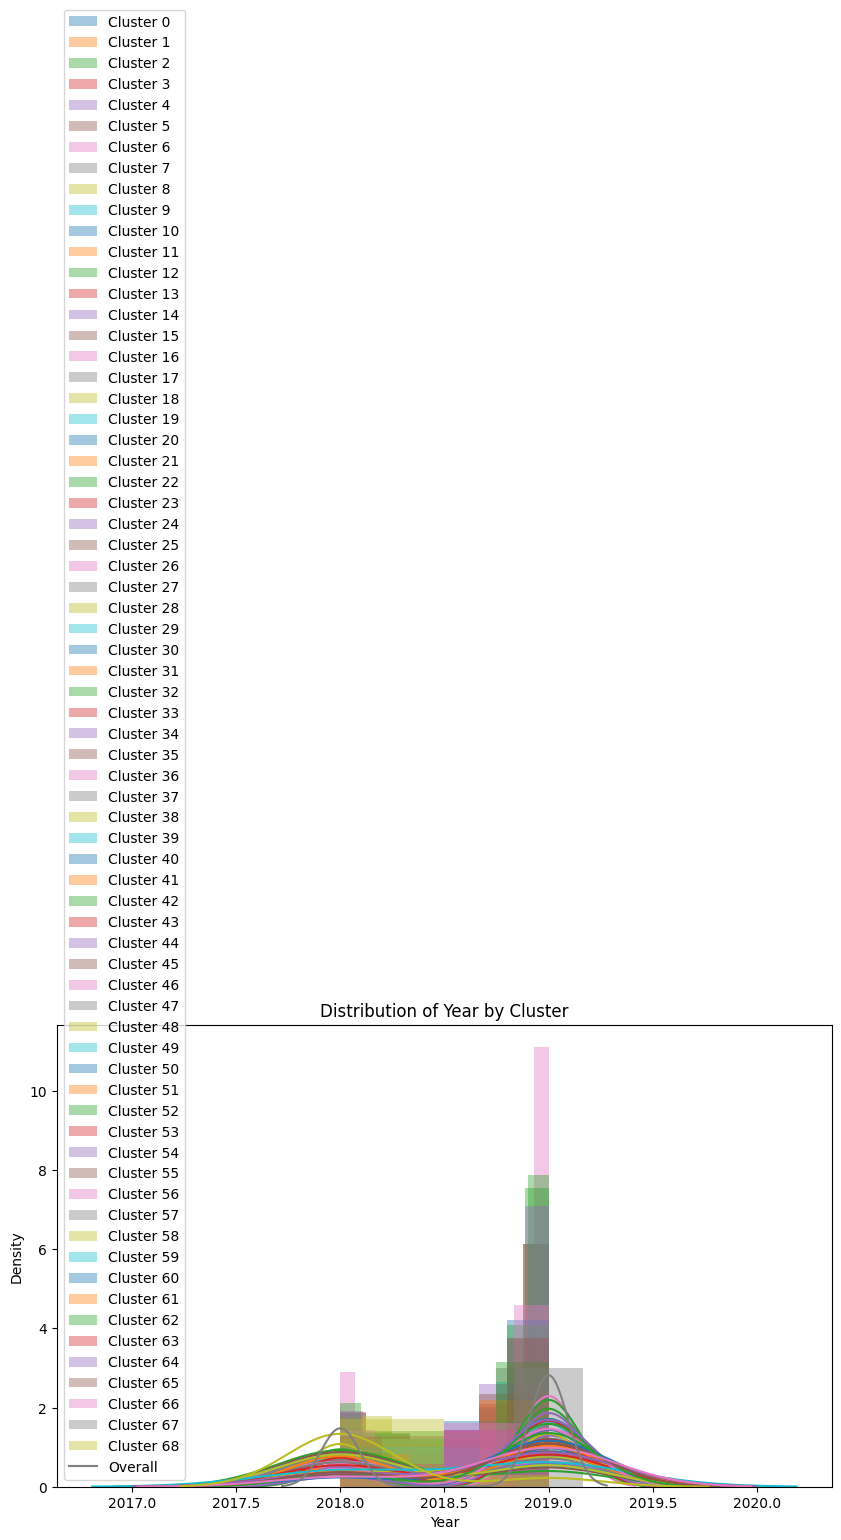

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

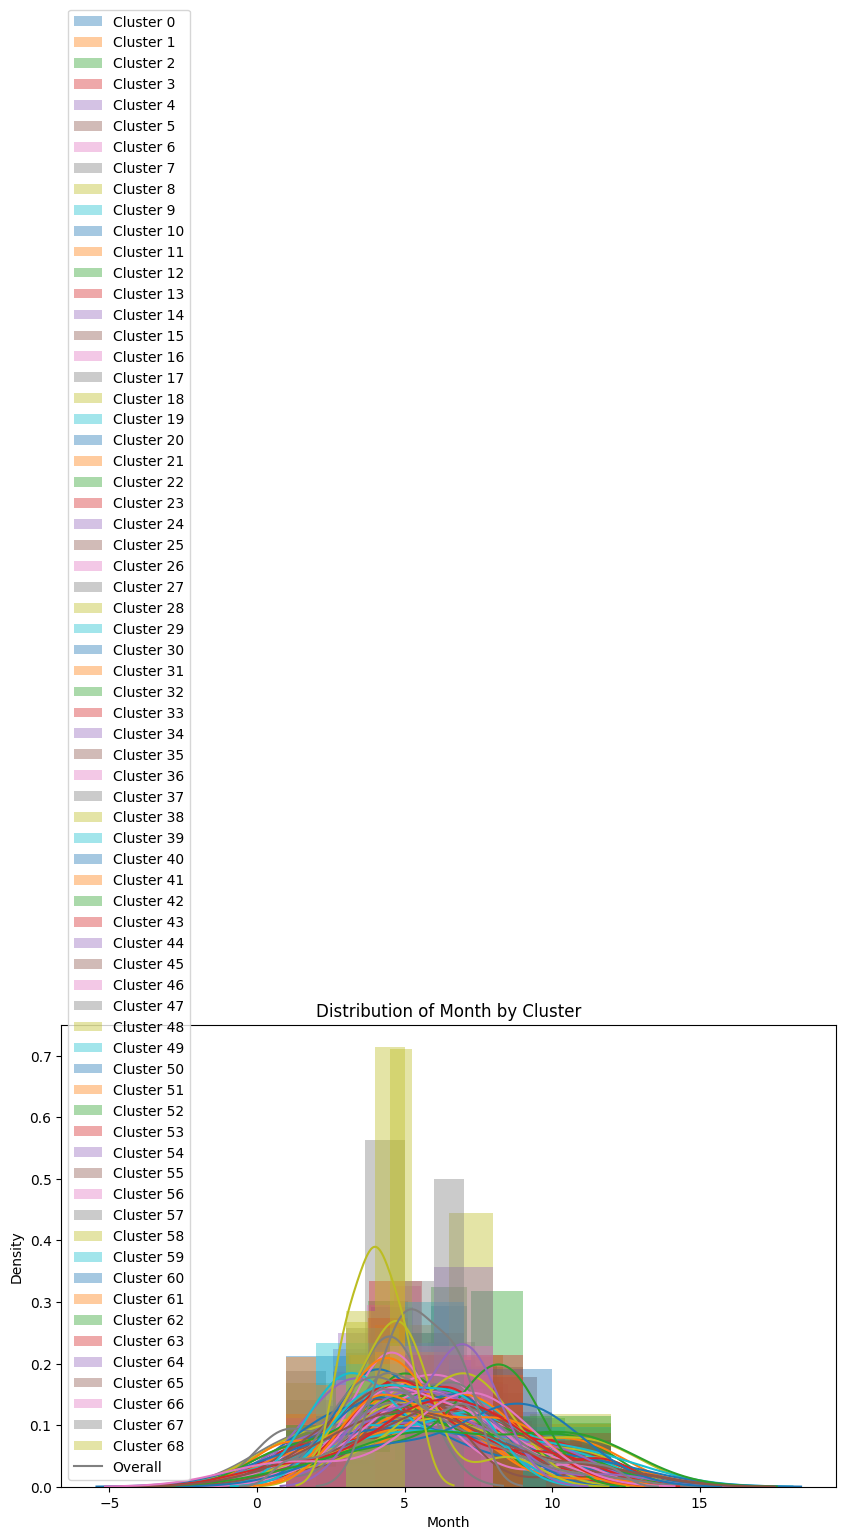

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

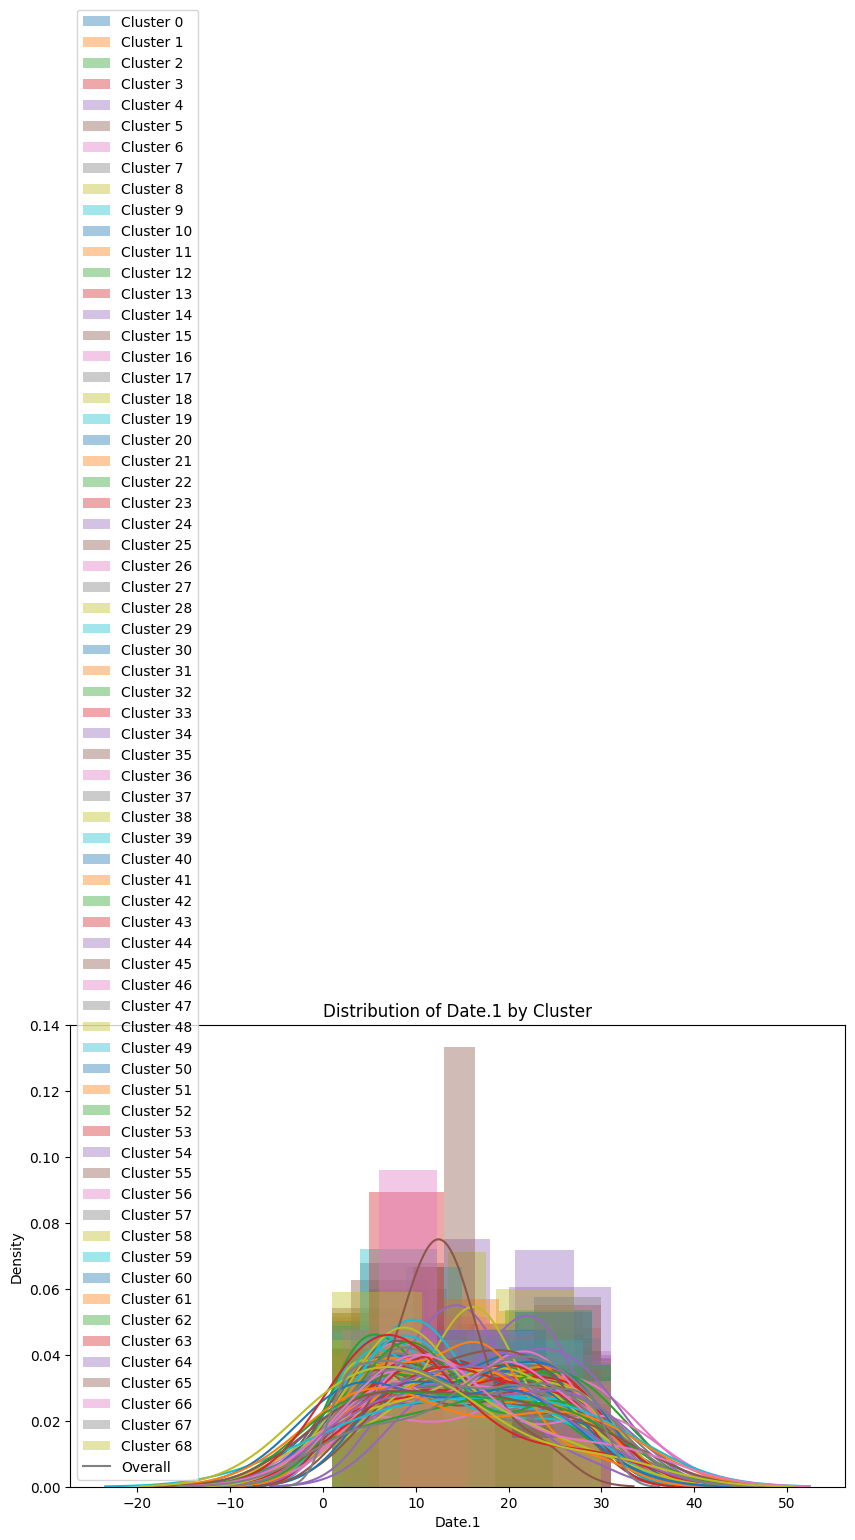

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

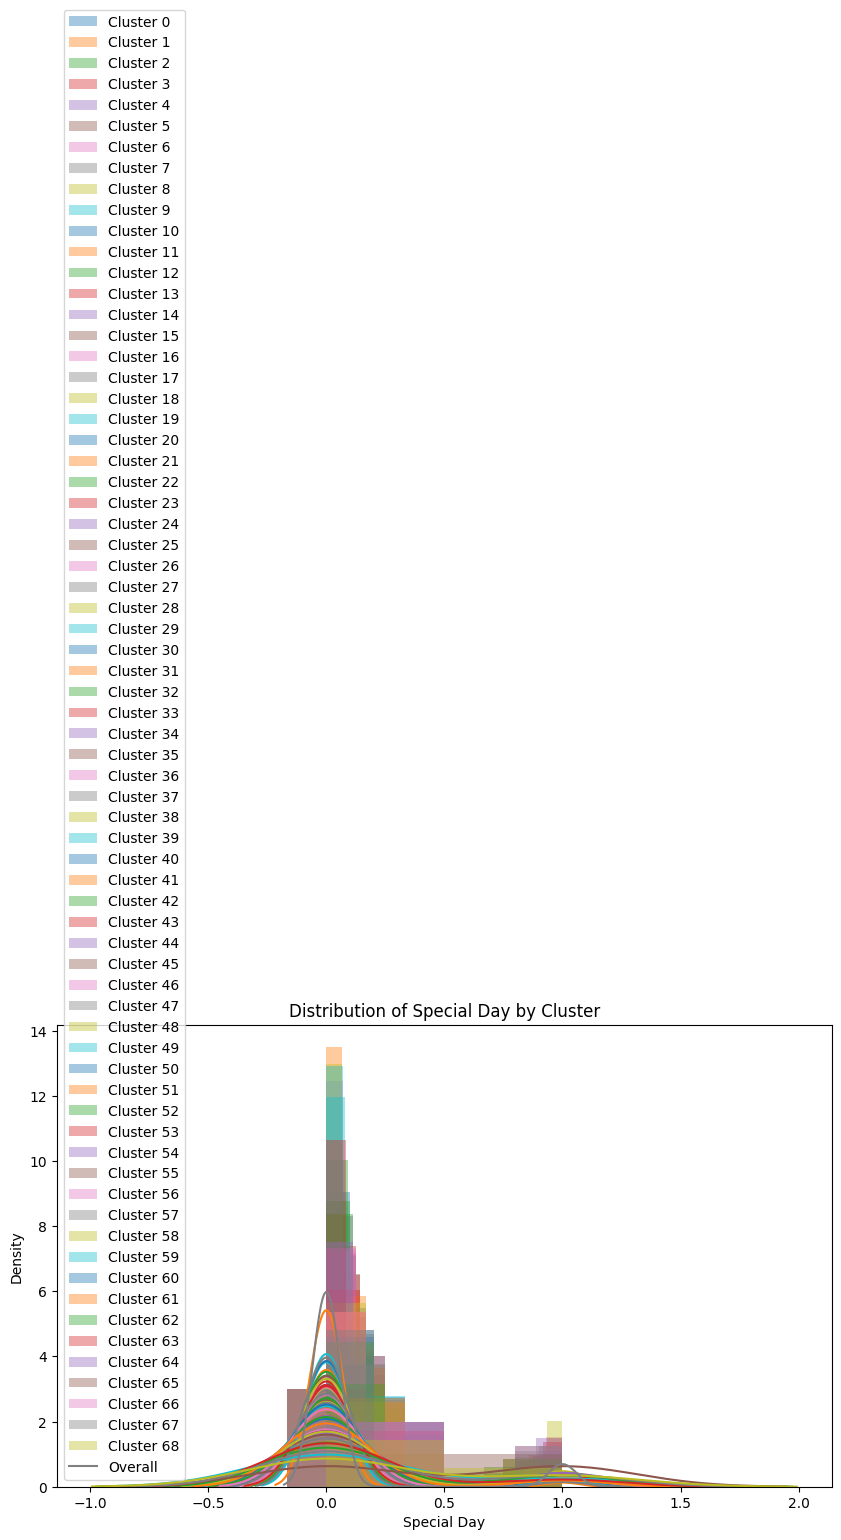

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

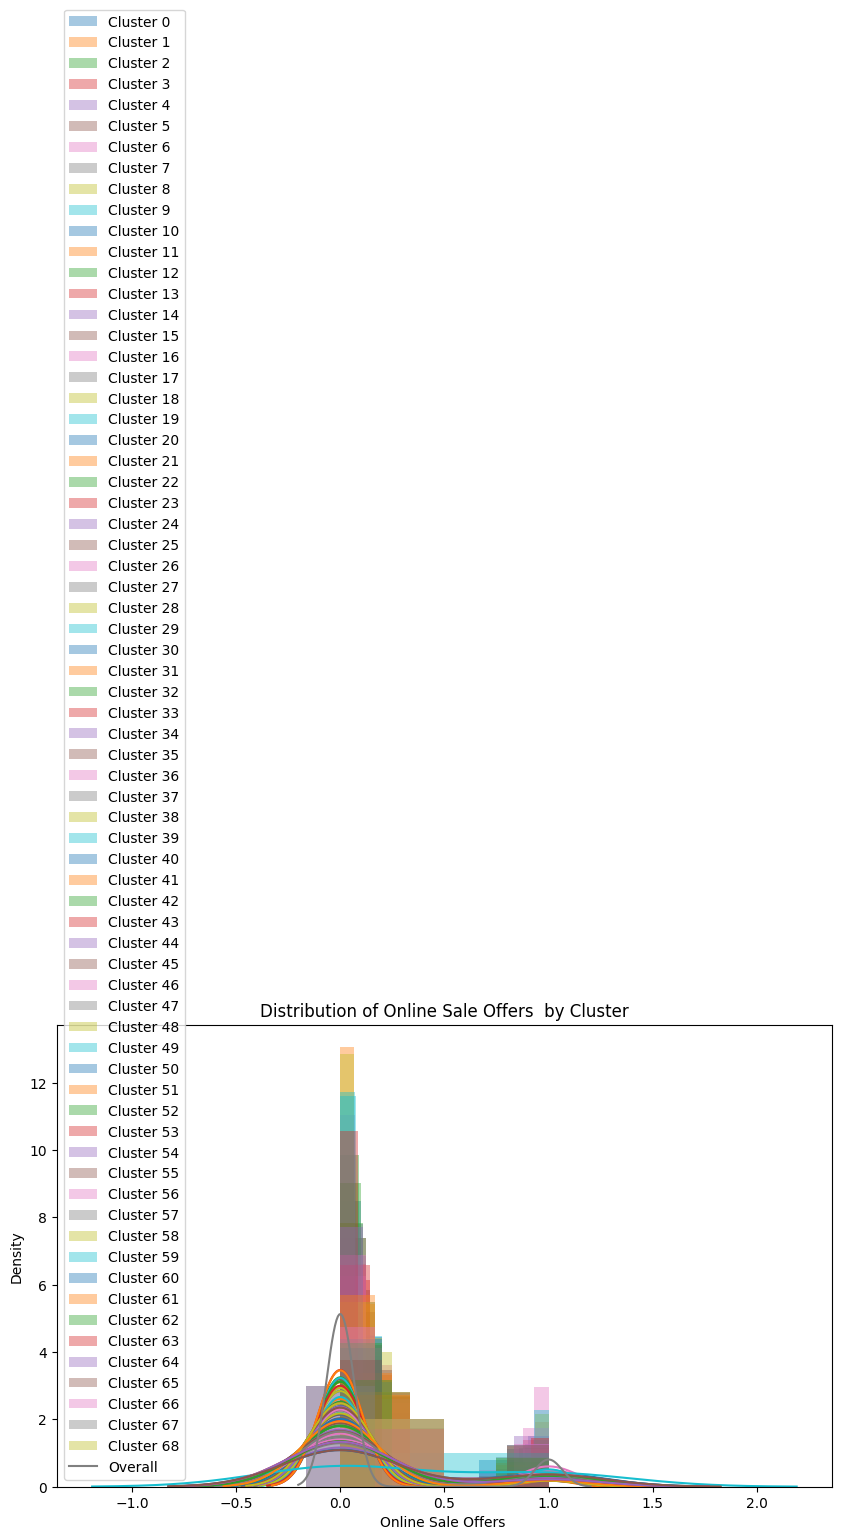

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

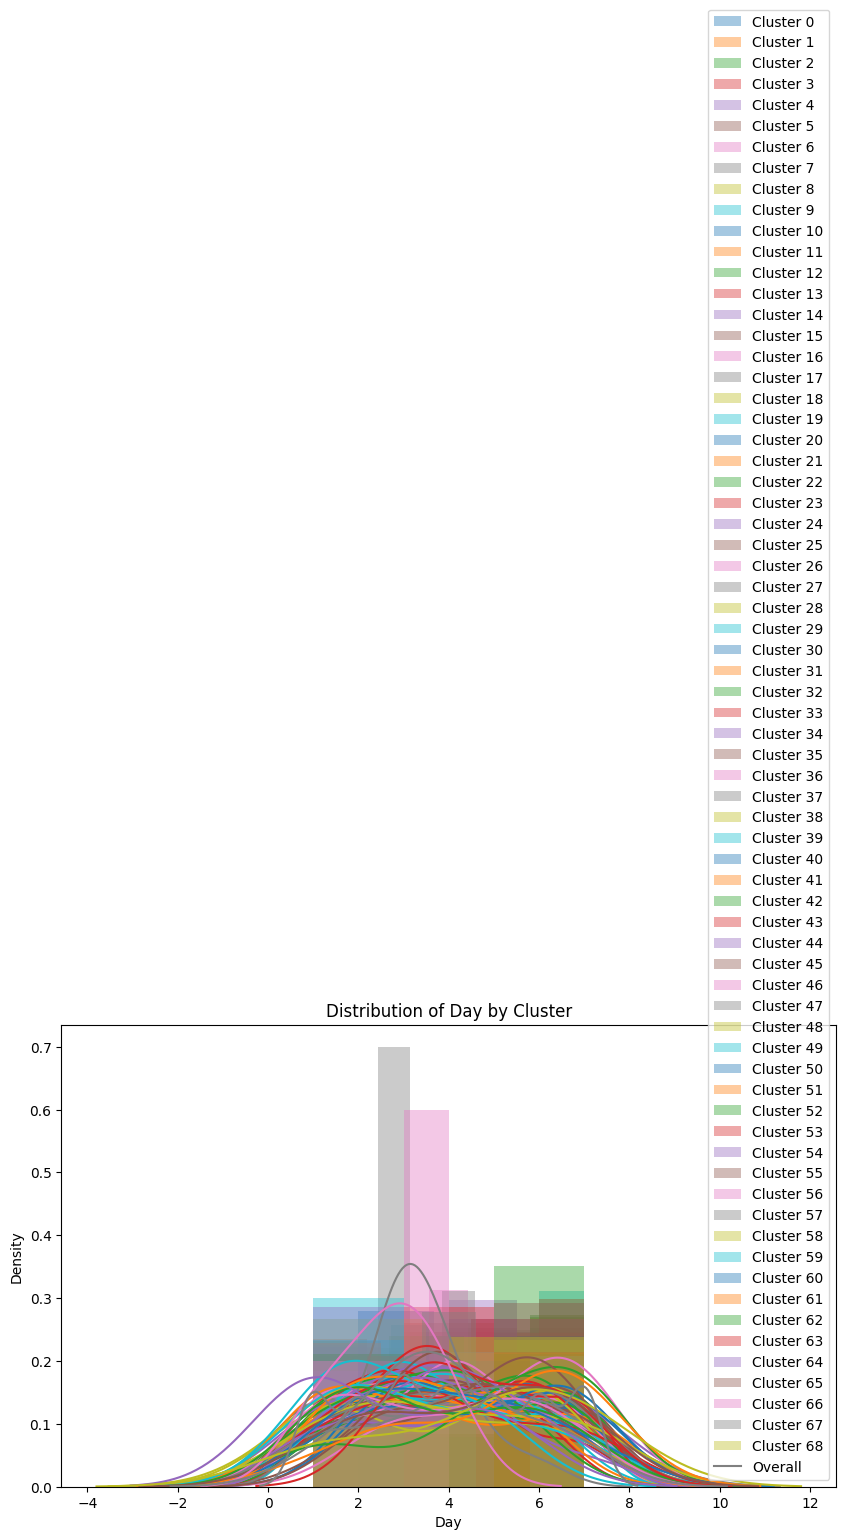

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

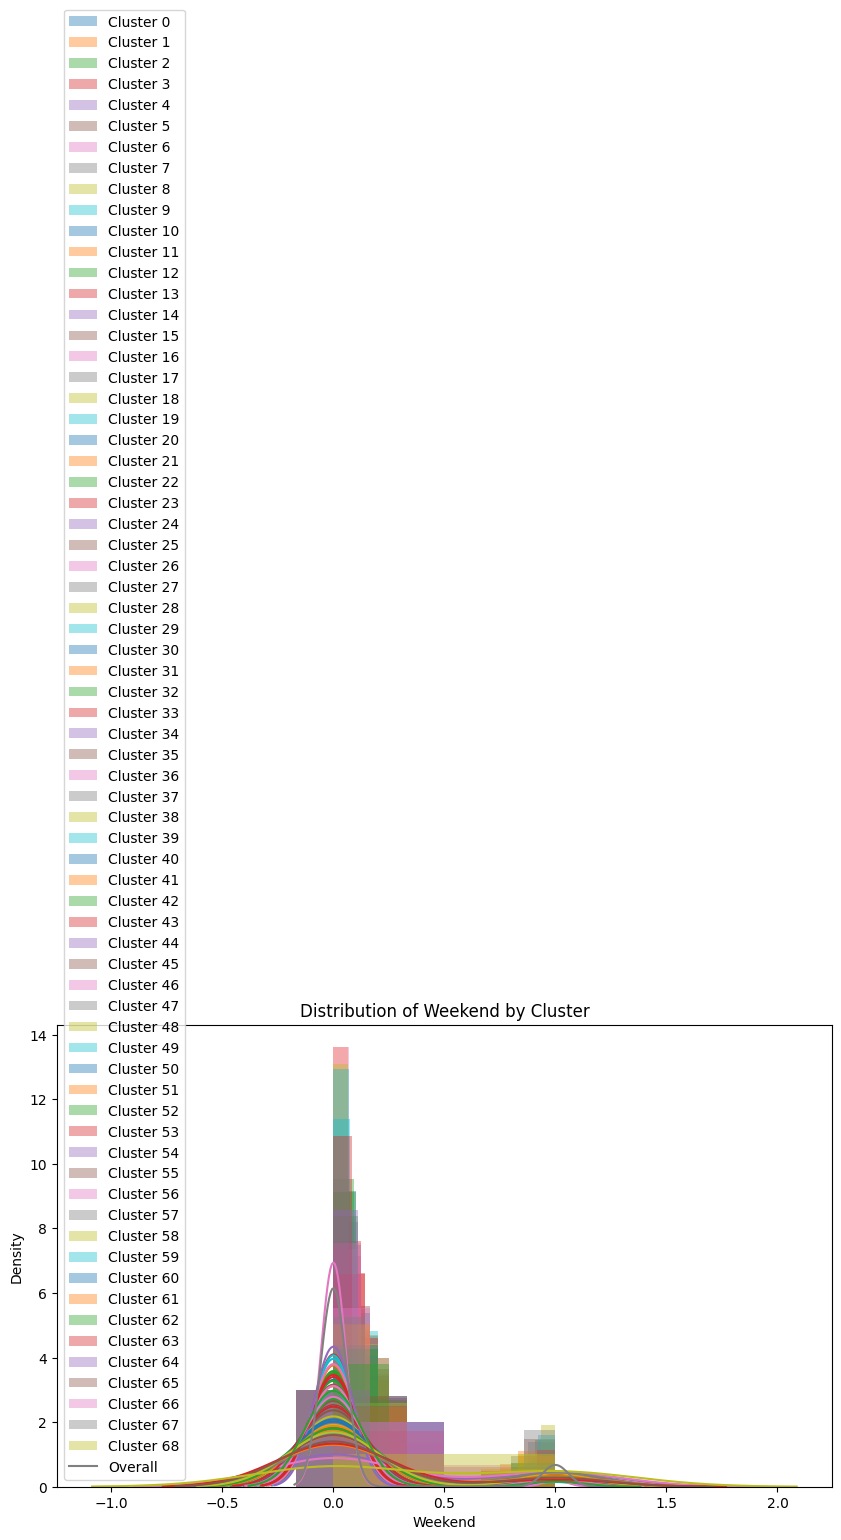

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

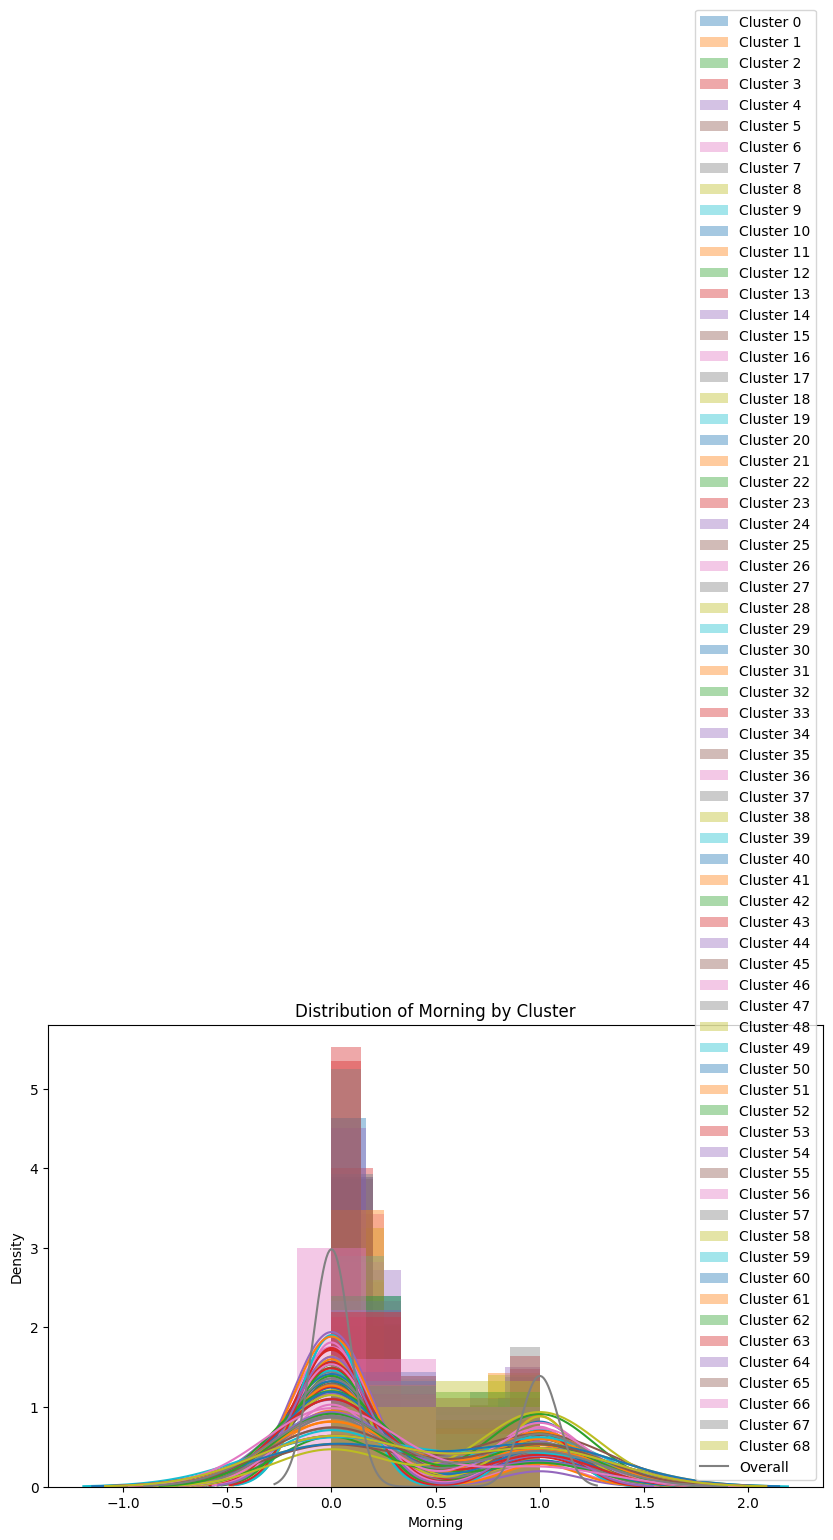

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

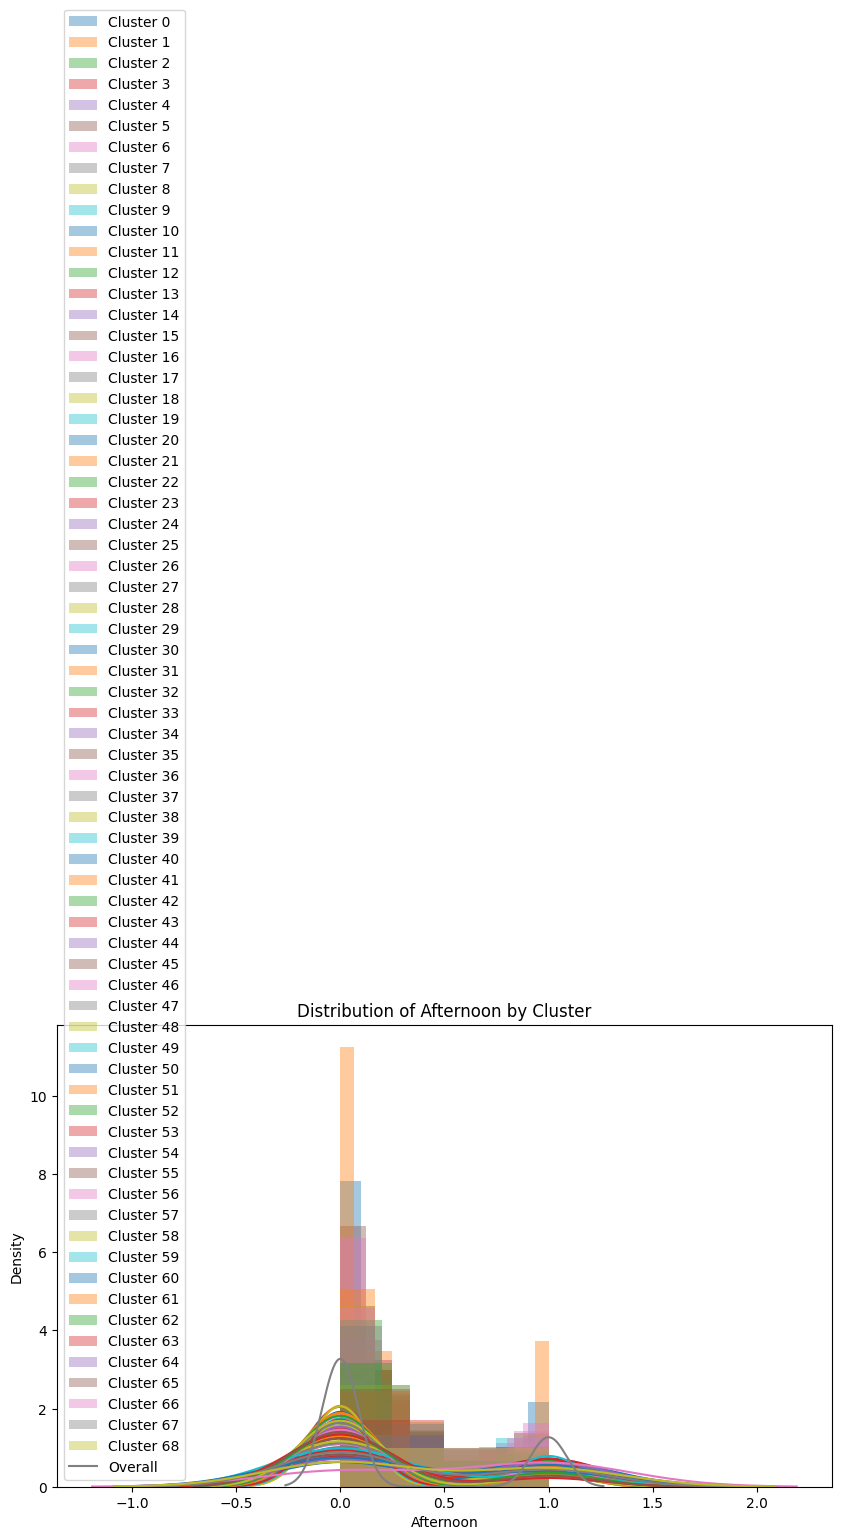

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

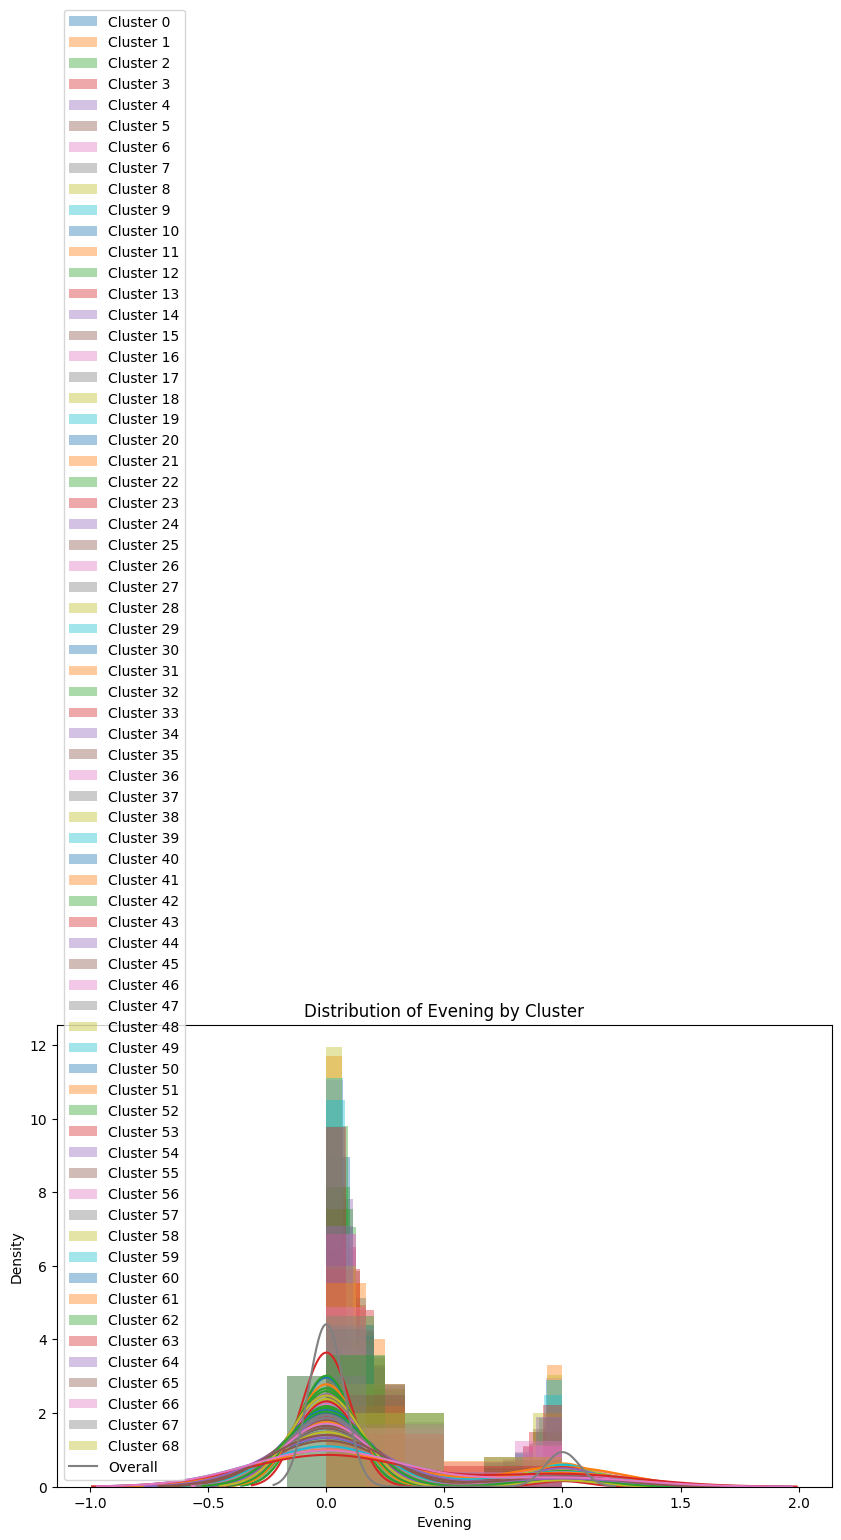

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

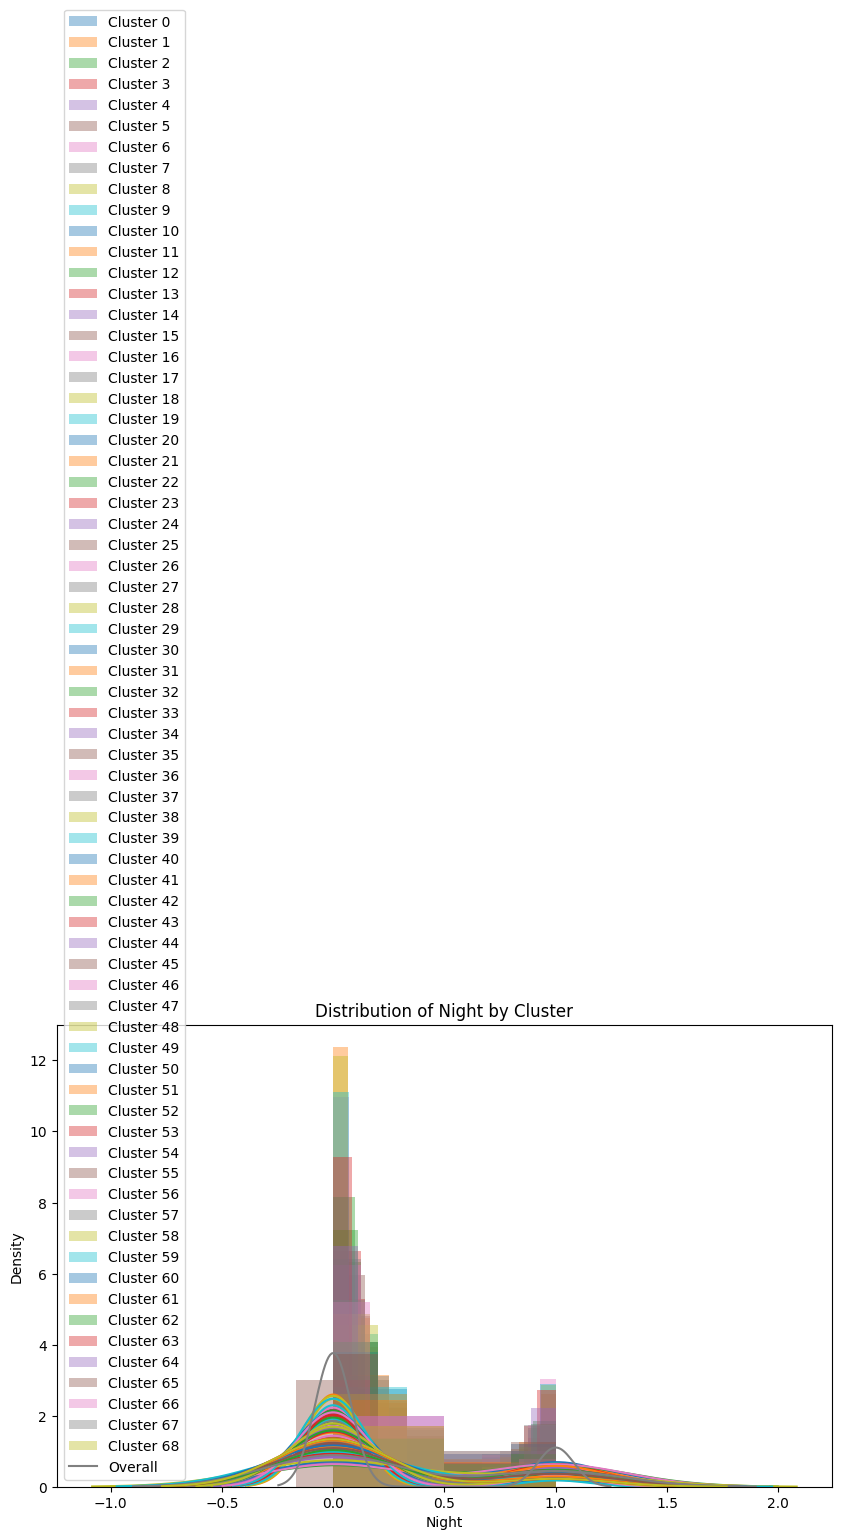

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

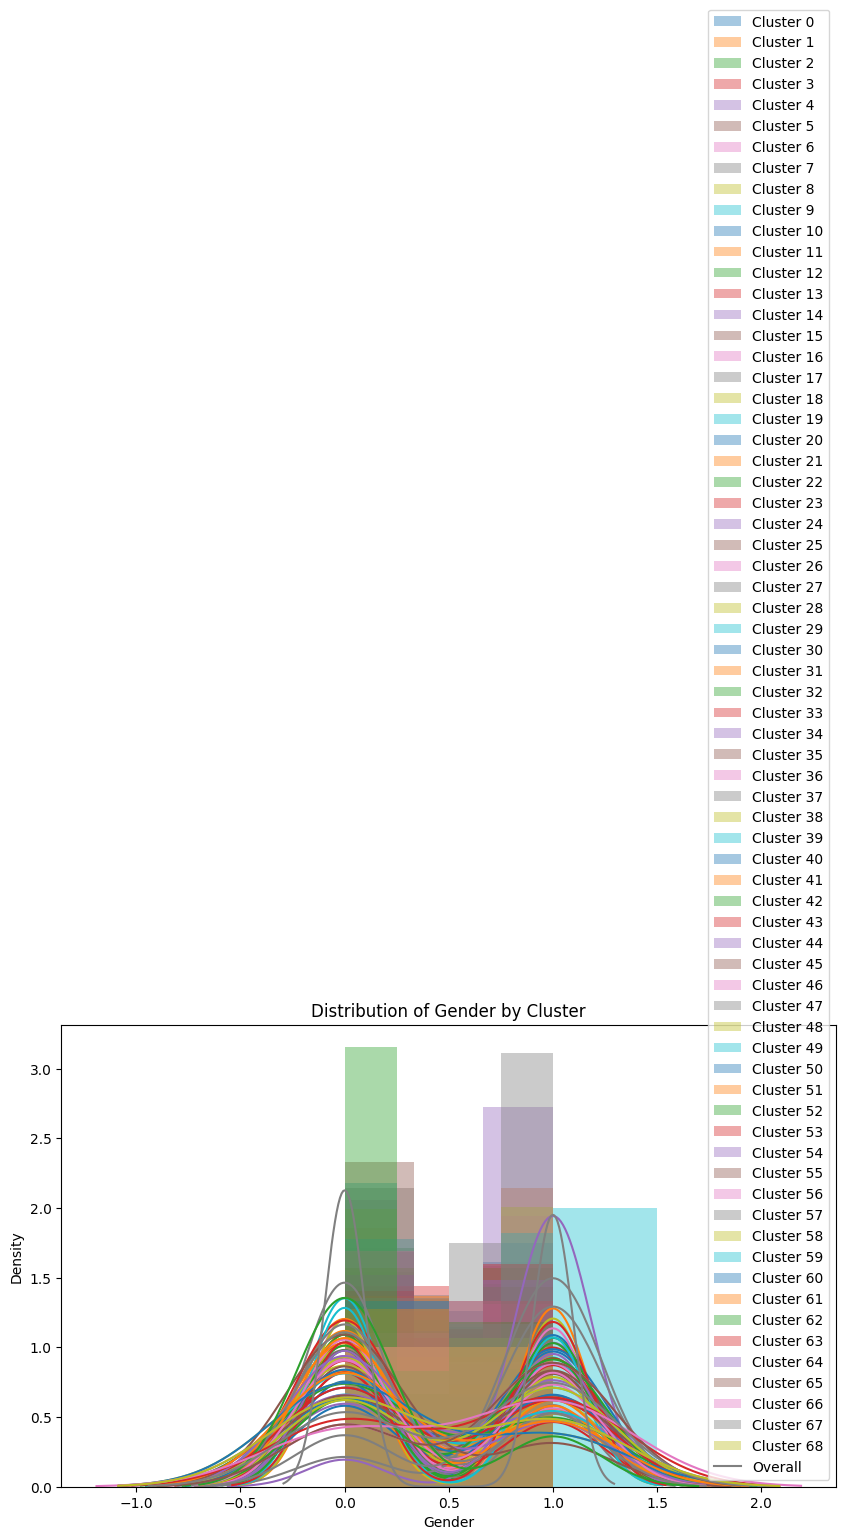

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

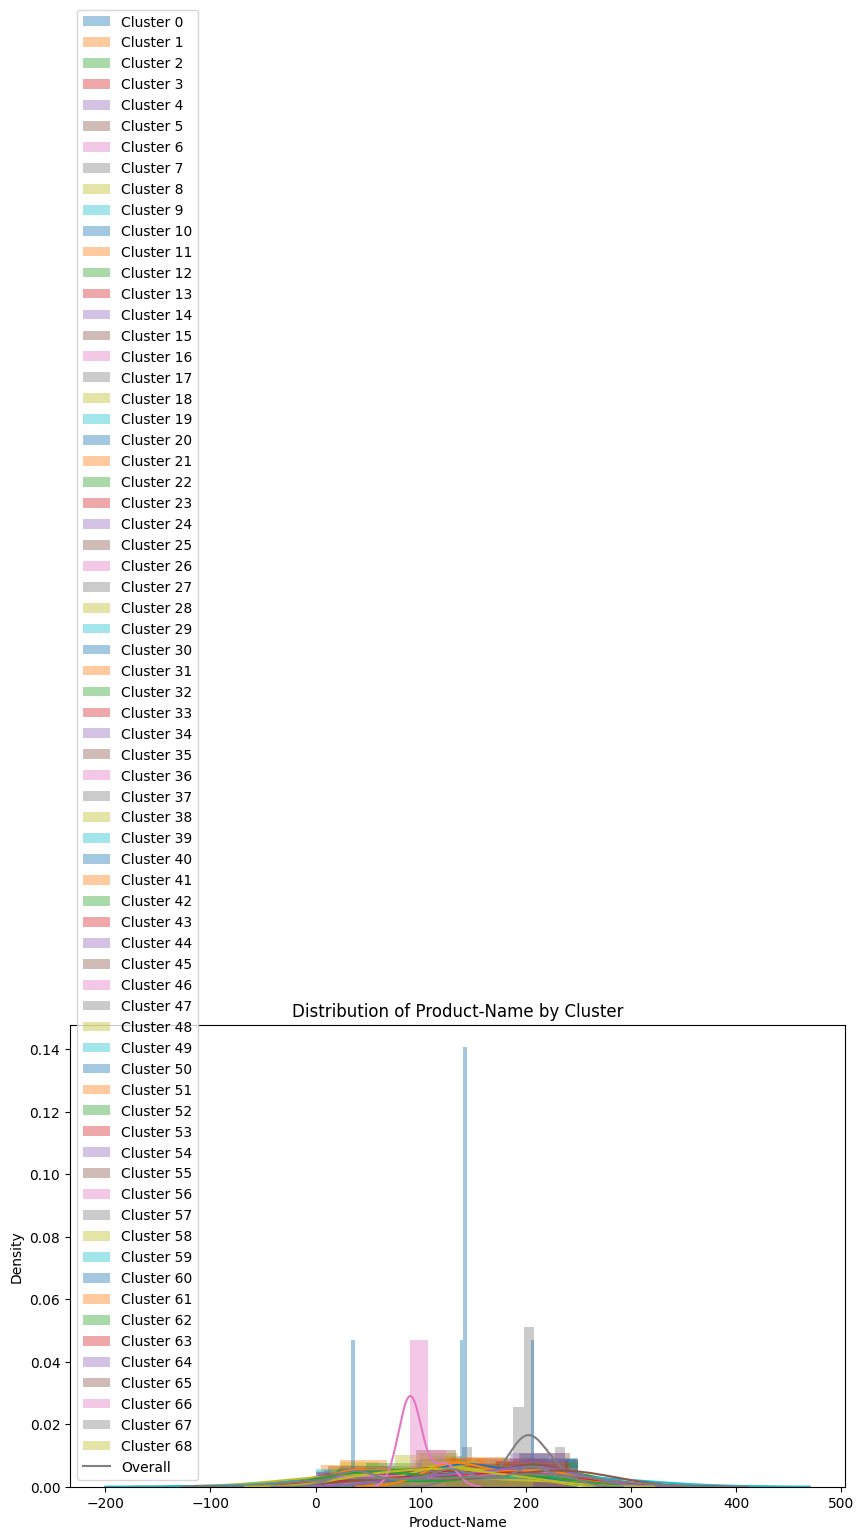

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

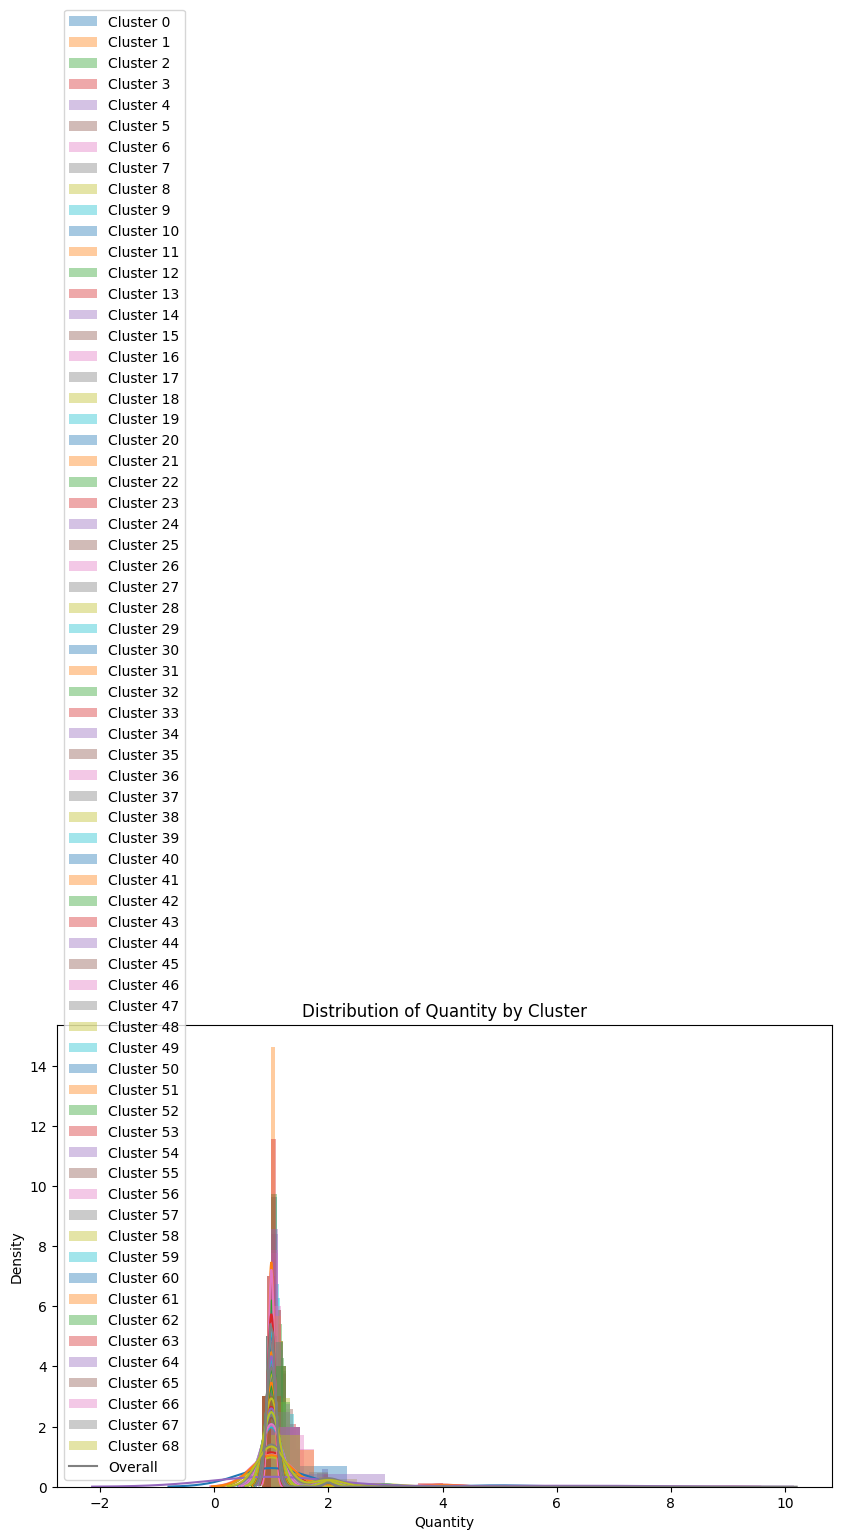

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

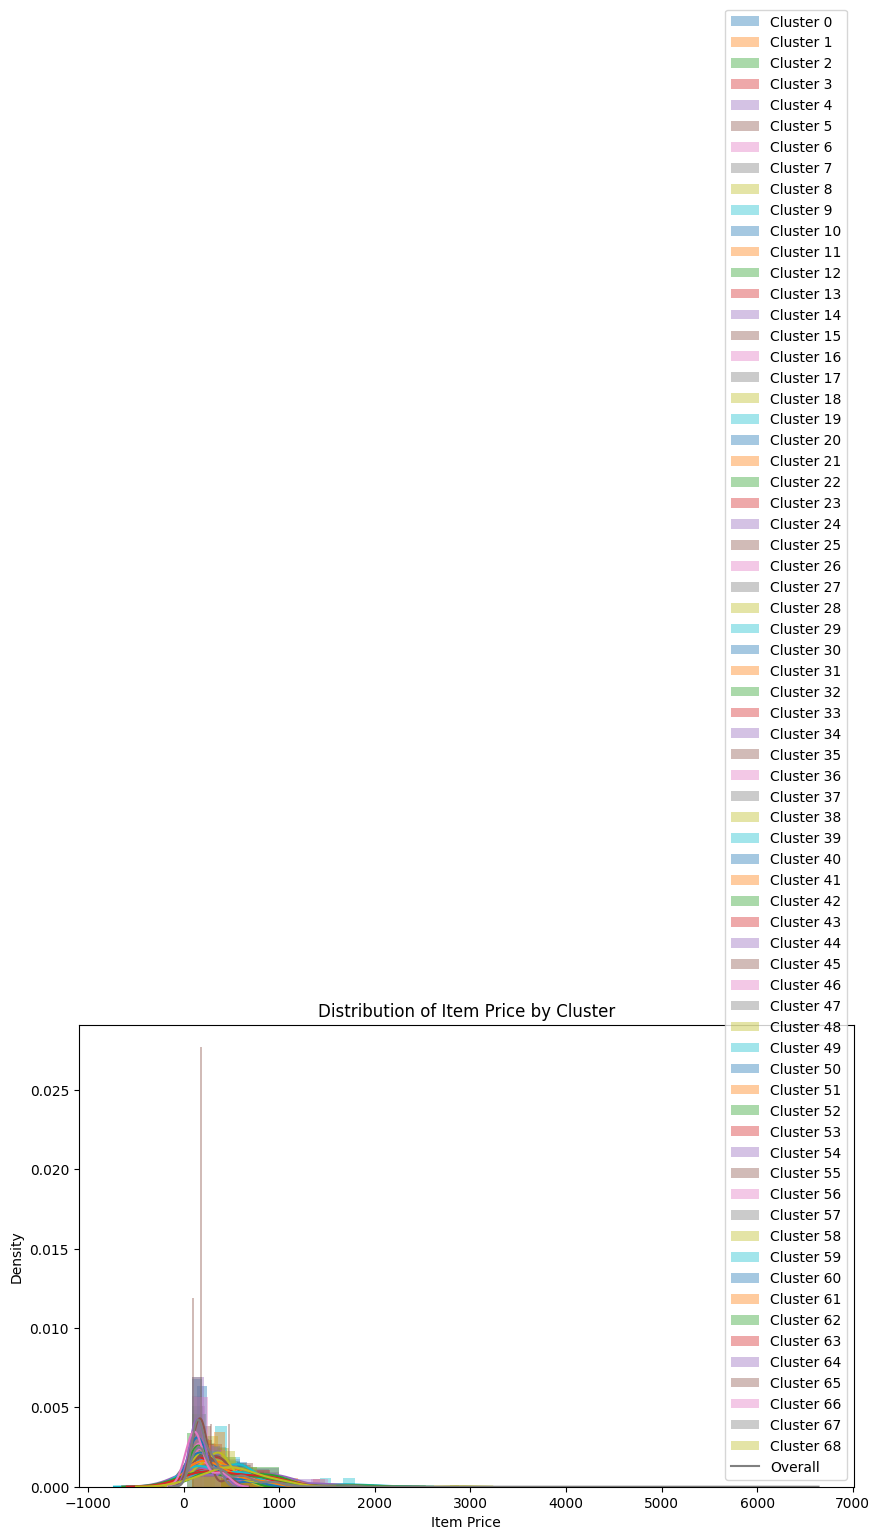

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

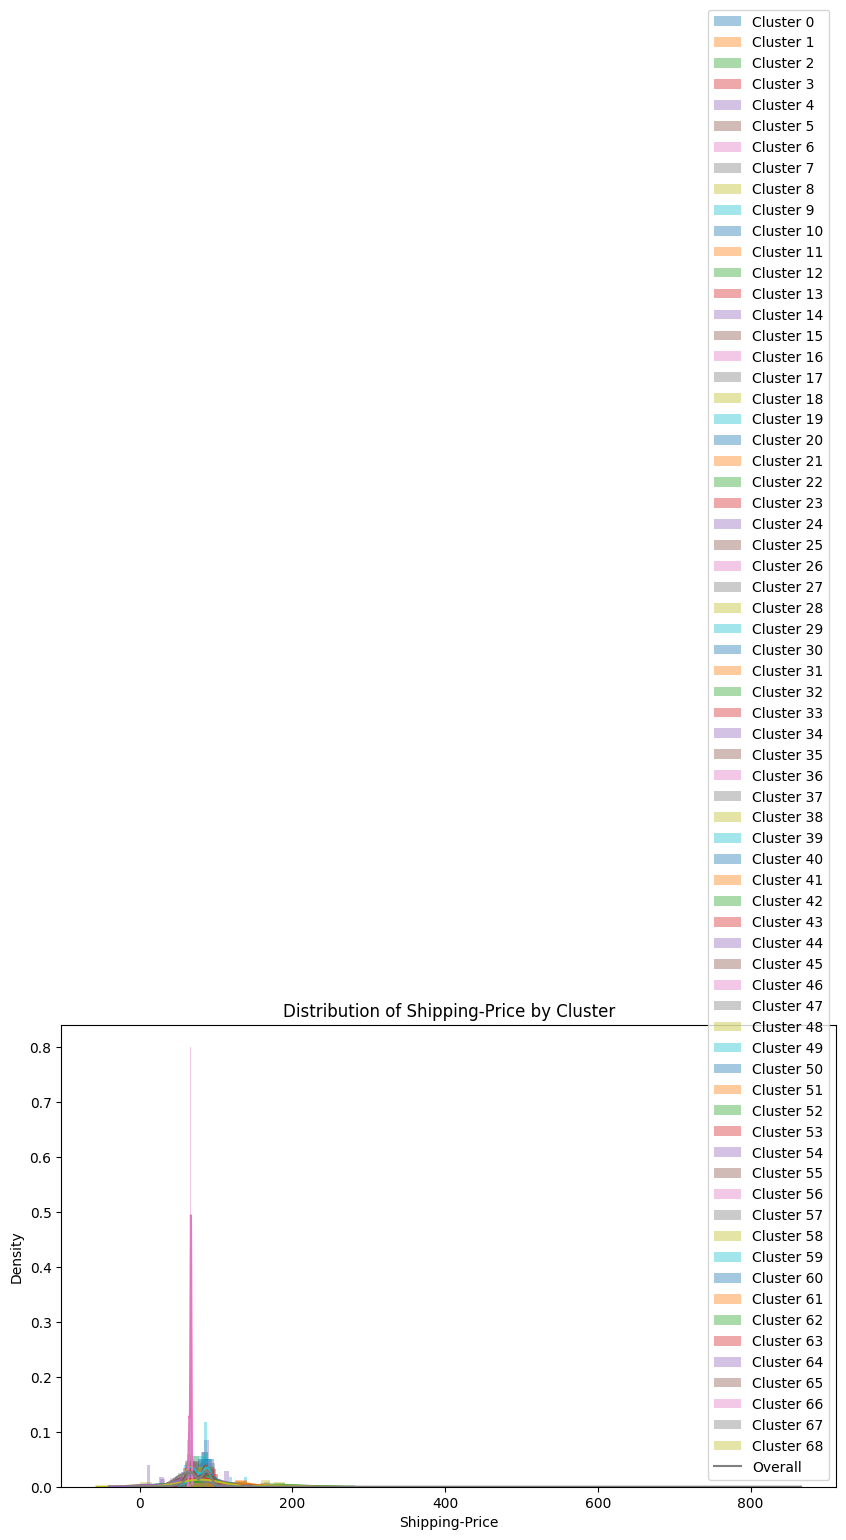

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

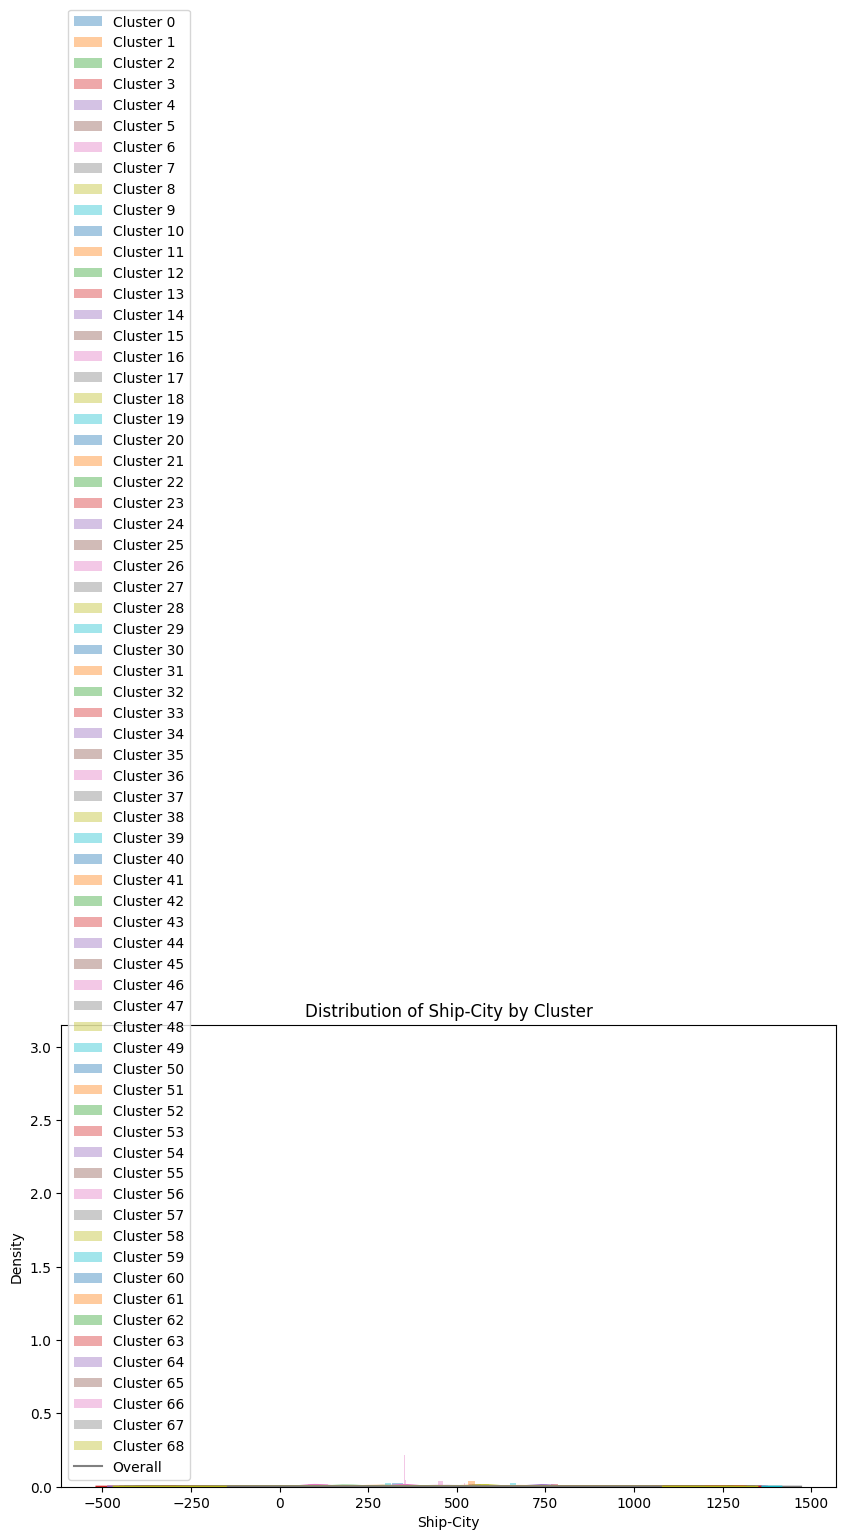

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

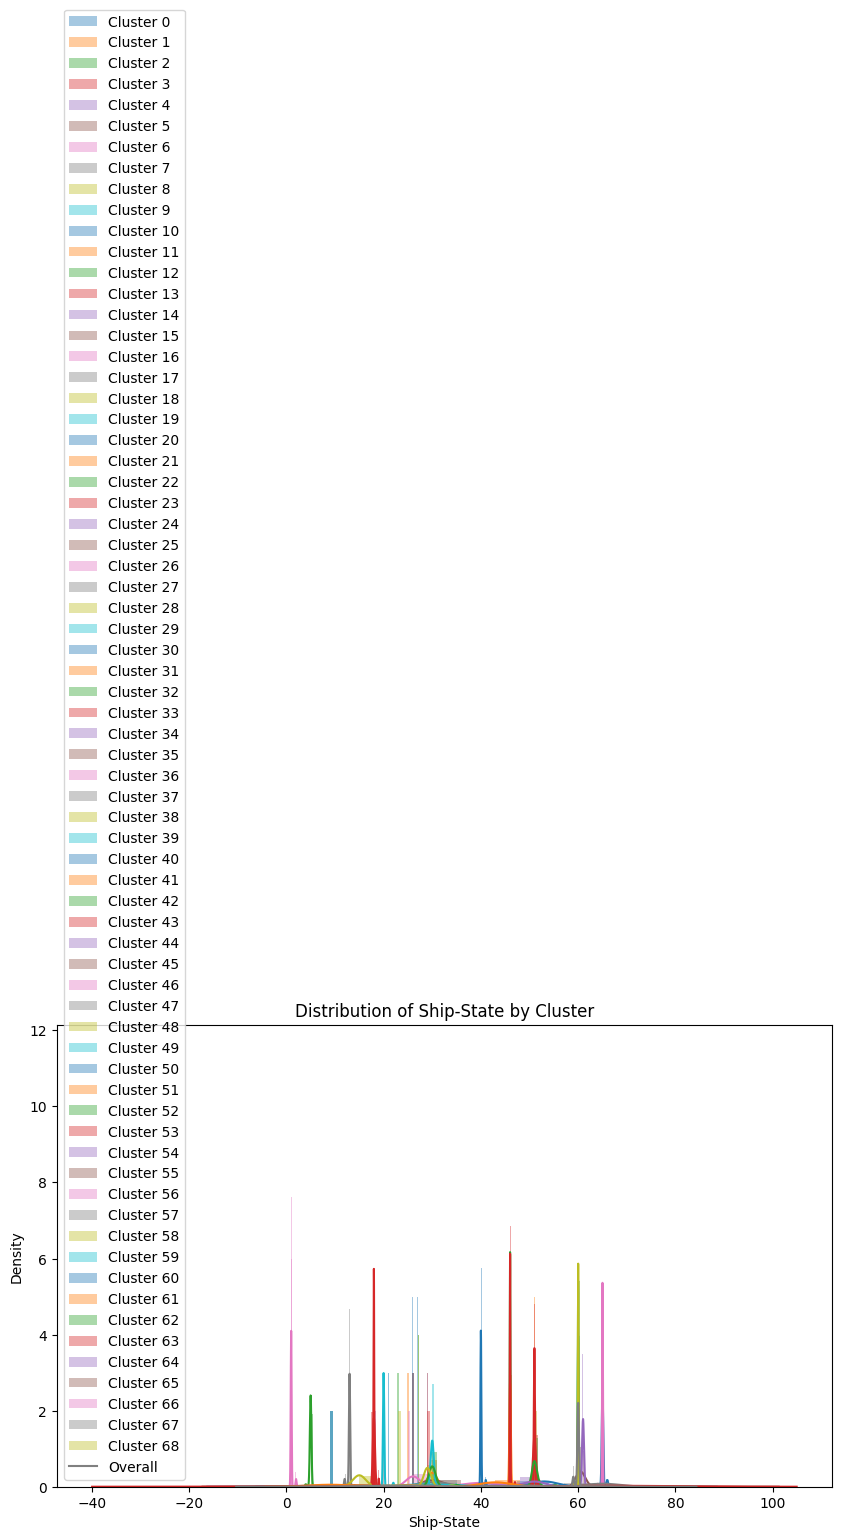

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

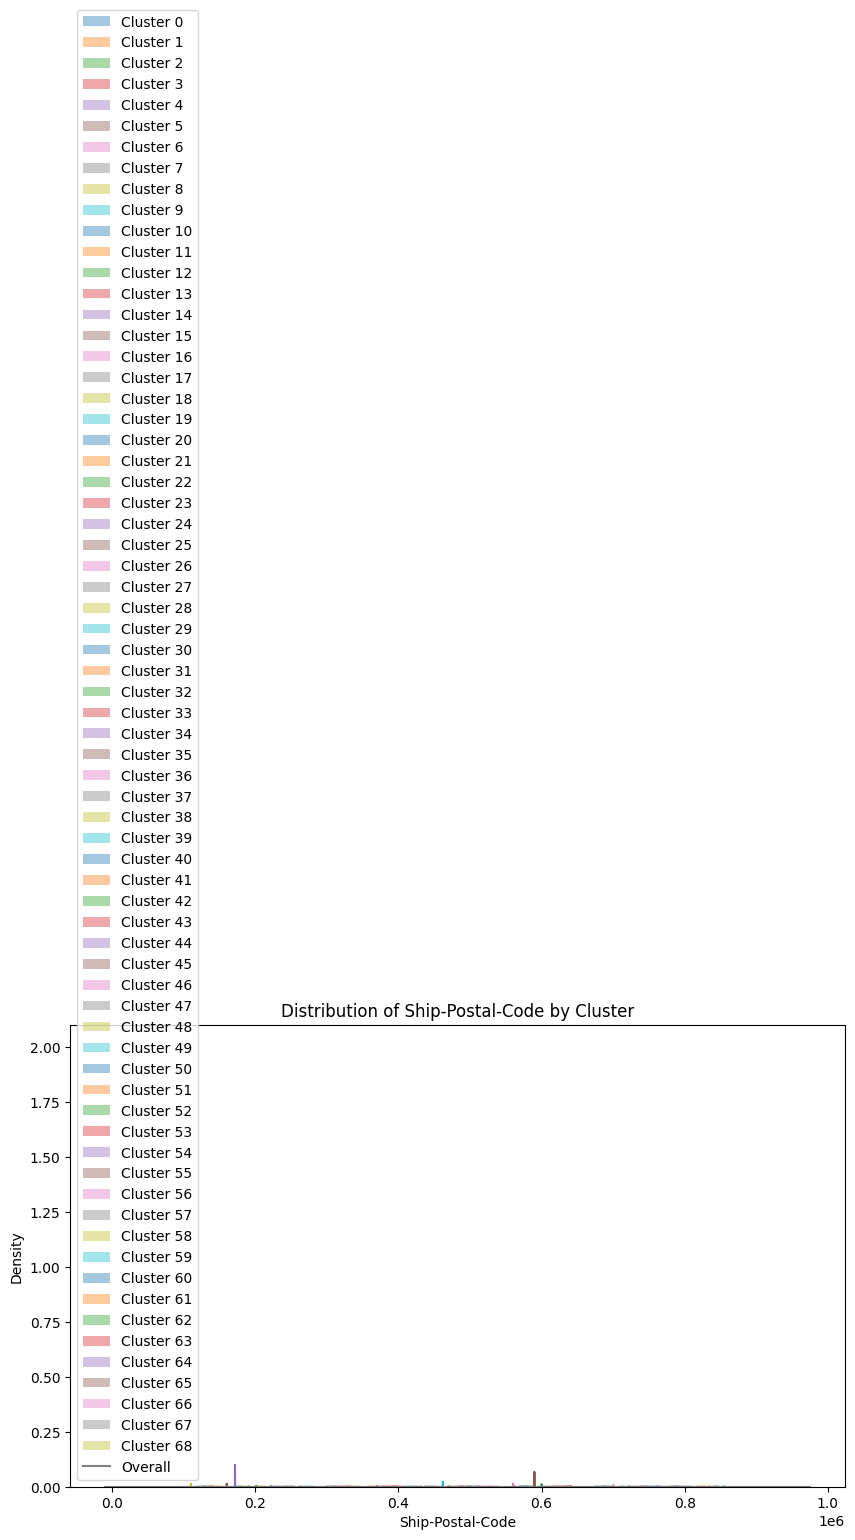

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

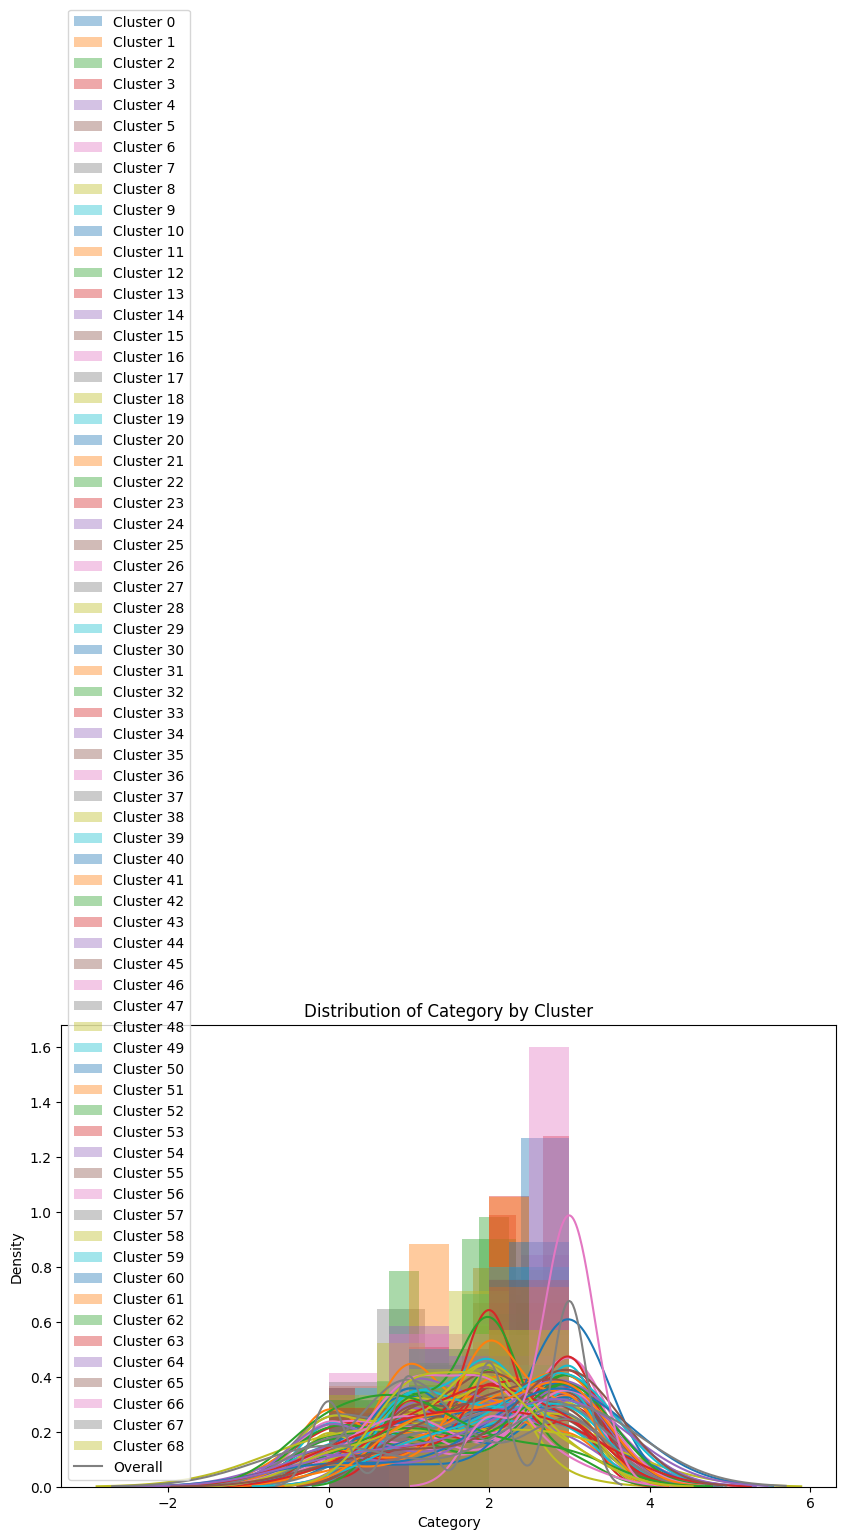

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

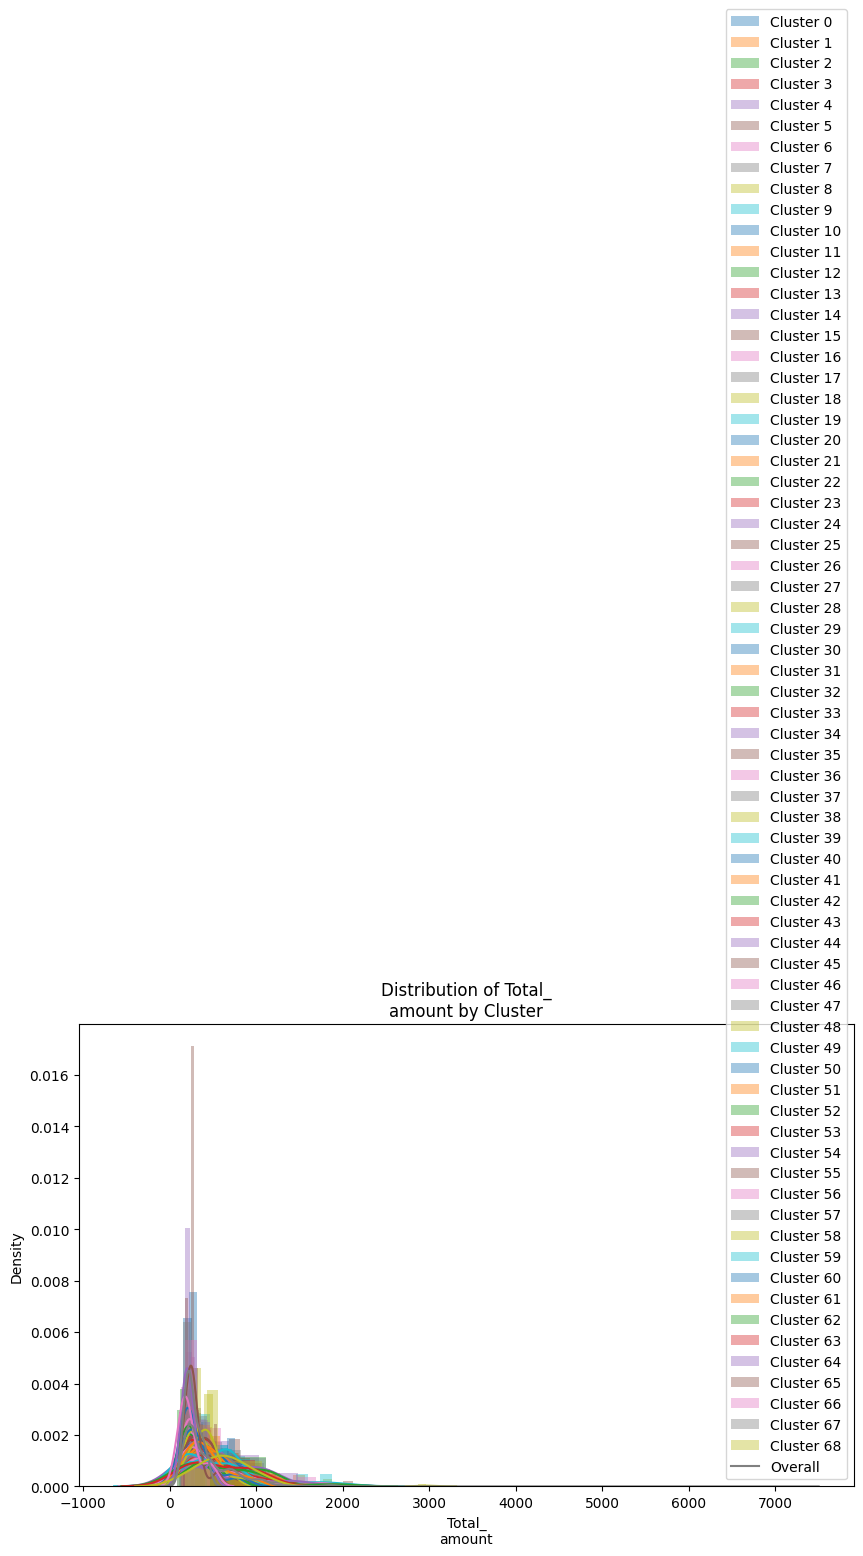

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

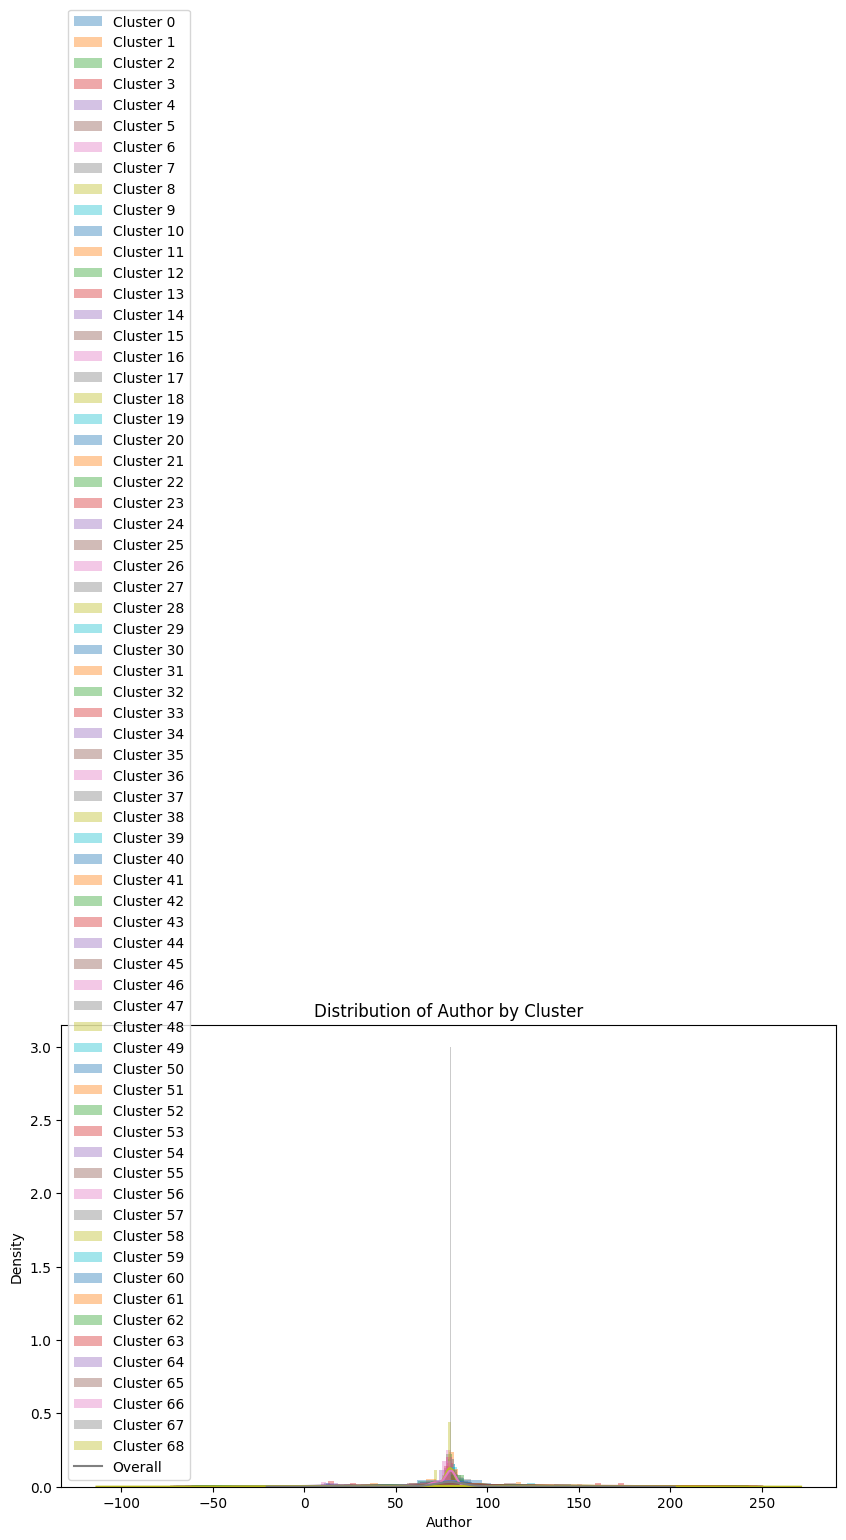

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

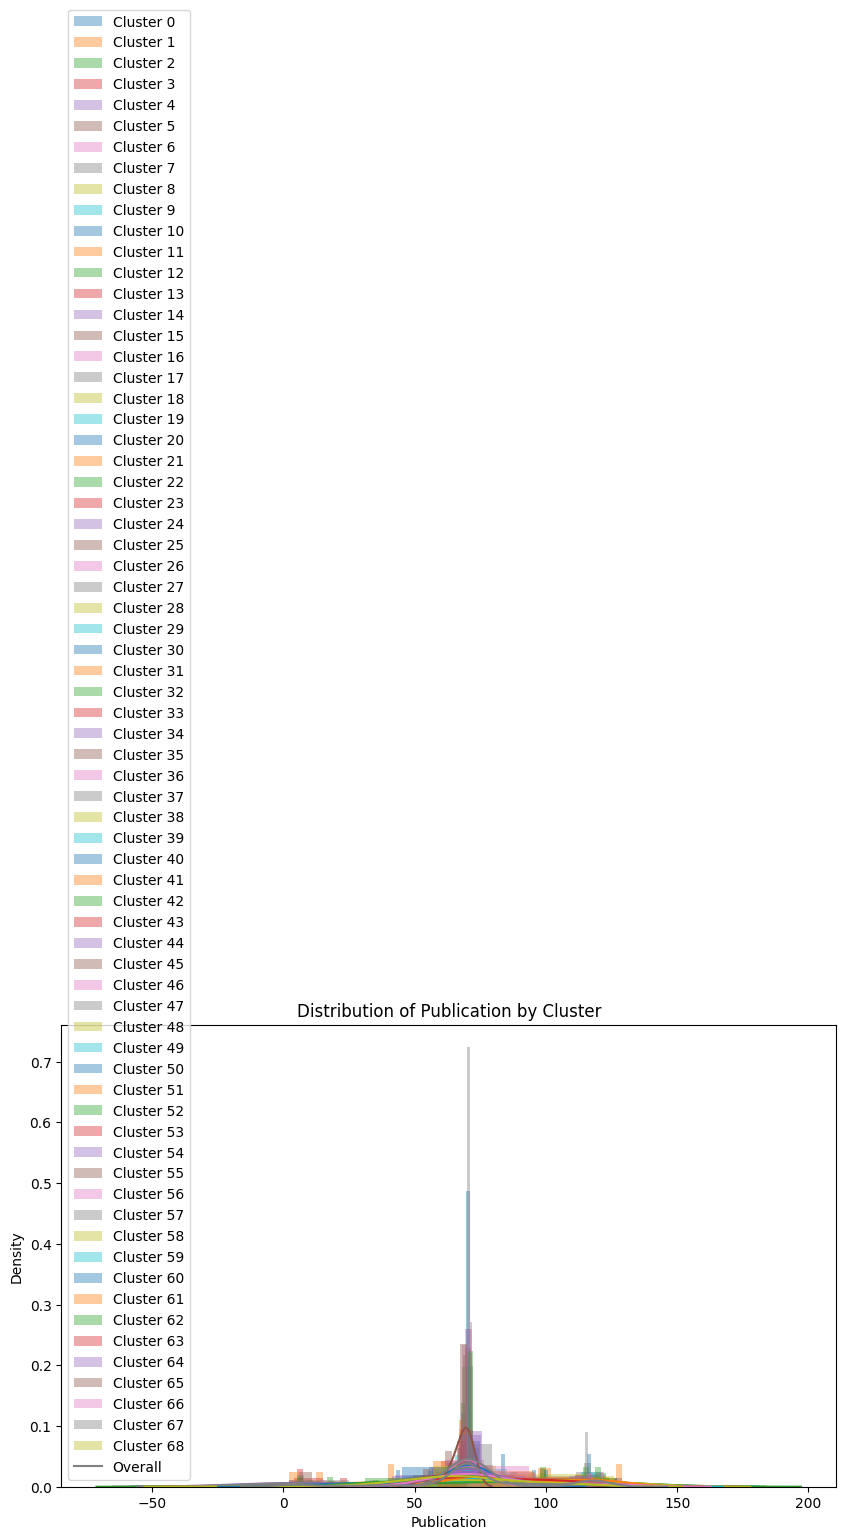

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

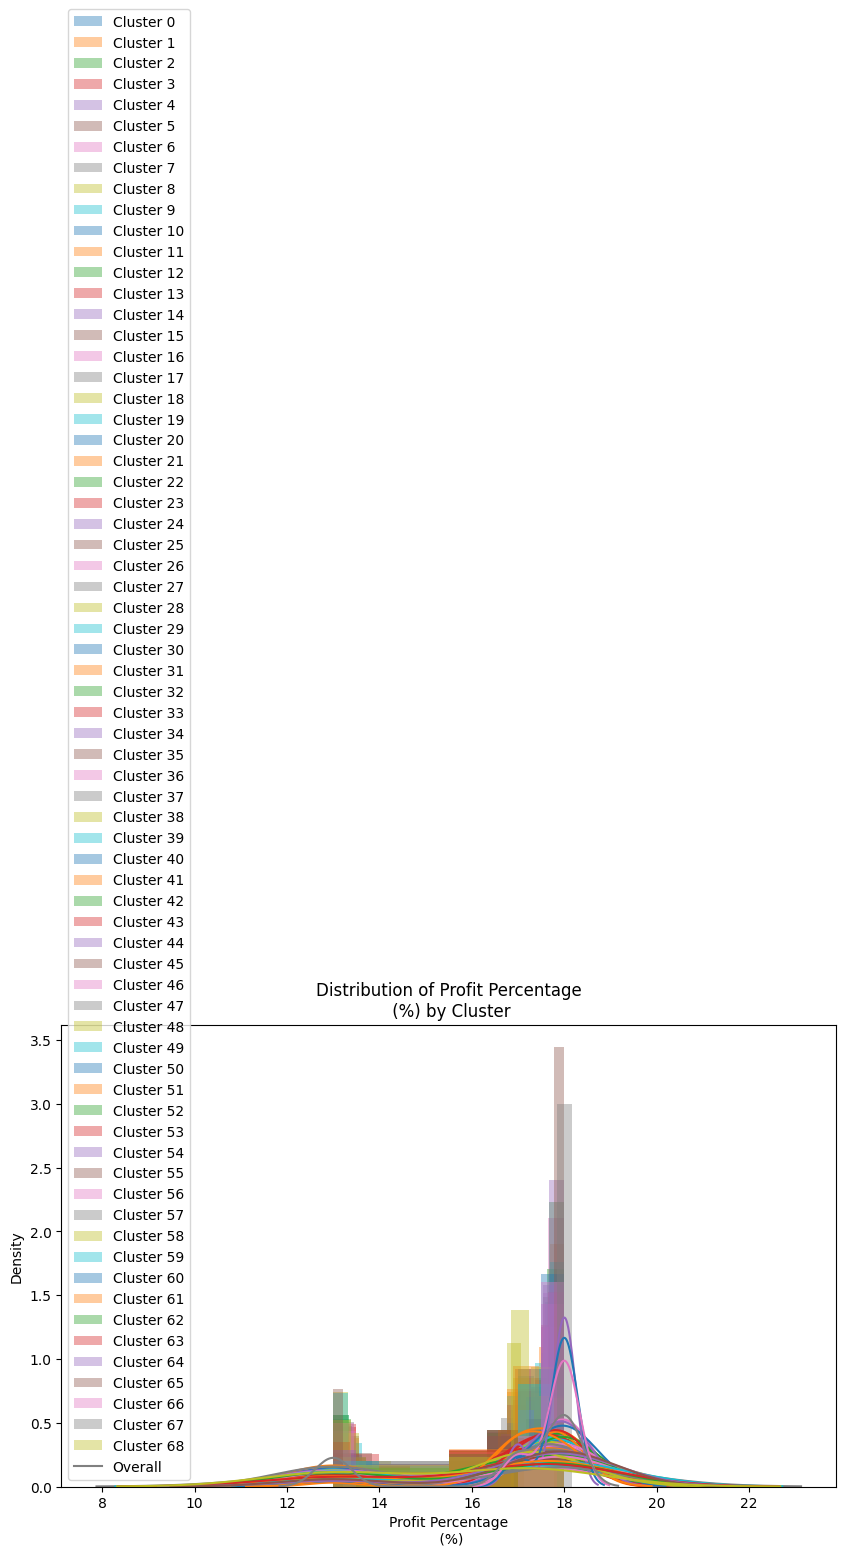

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

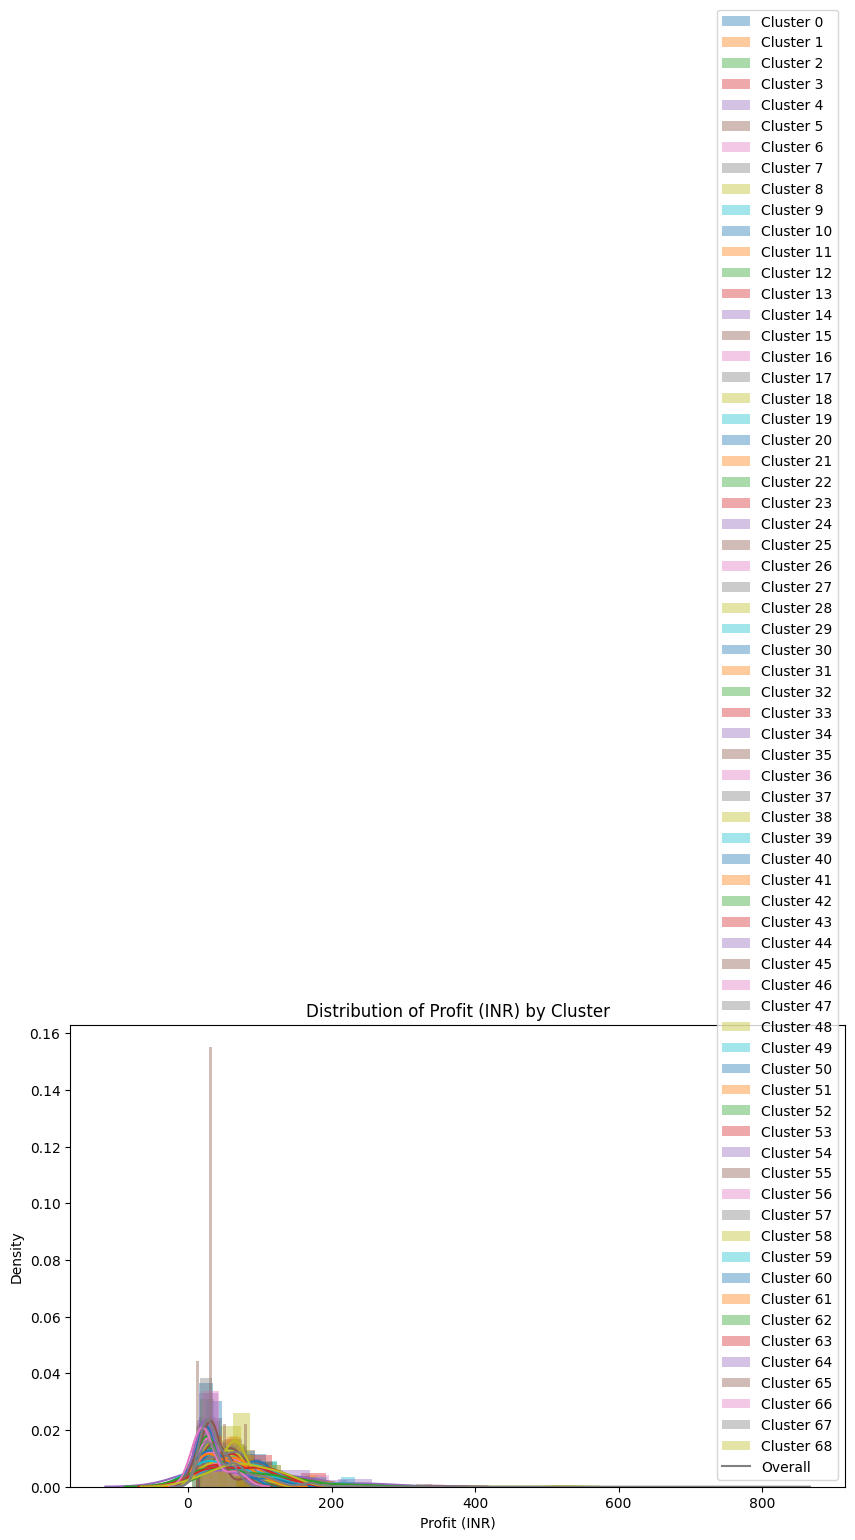

/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_4940/2350363521.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

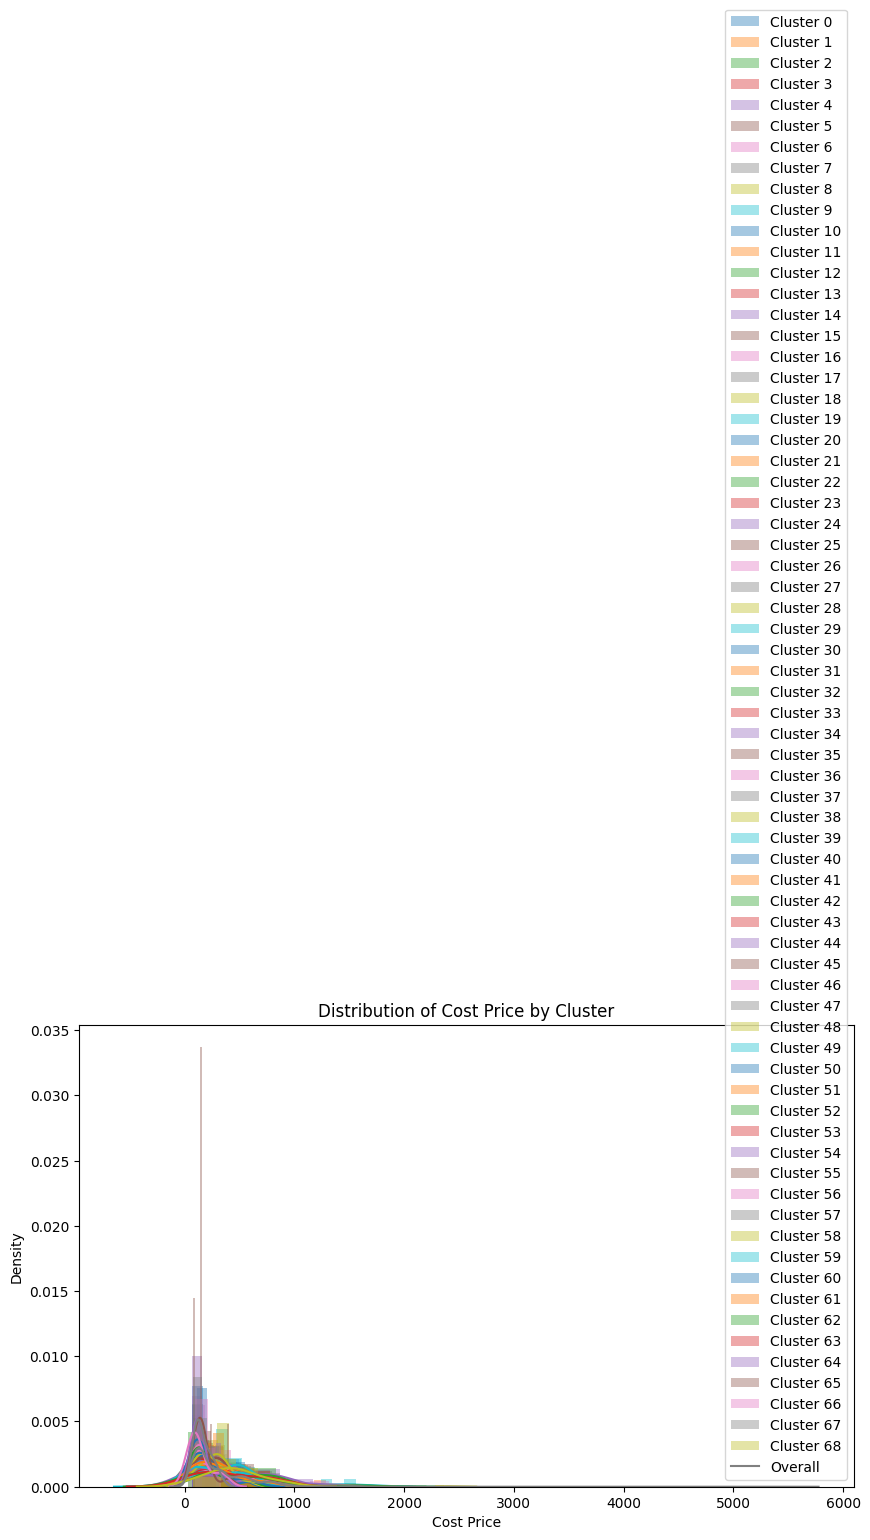

In [17]:
# Visualizing feature distributions for each cluster
features = df.columns[:-1]  # Exclude the cluster label column
n_features = len(features)
n_clusters = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)  # Exclude noise if present

for feature in features:
    plt.figure(figsize=(10, 6))
    for cluster in range(n_clusters):
        sns.distplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}')
    sns.distplot(df[feature], label='Overall', color='gray', hist=False)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.legend()
    plt.show()

Hijerarhijska klasterizacija

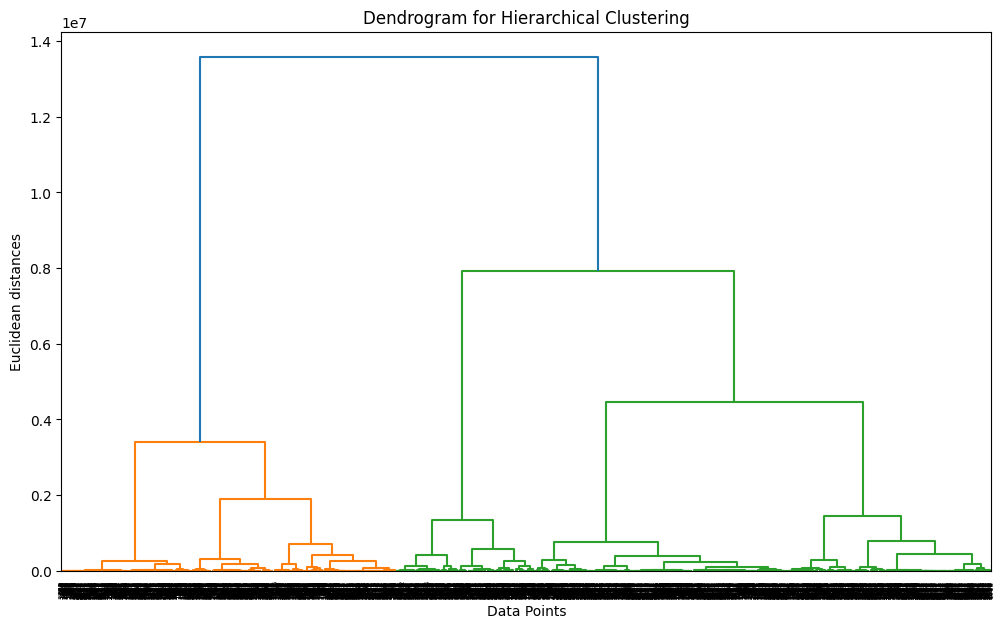

/Users/filipnikolic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Silhouette Score for Hierarchical Clustering:  0.6618090596870916


In [20]:
# Hierarchical Clustering
Z = linkage(df, method='ward')
plt.figure(figsize=(12, 7))
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Euclidean distances')
plt.show()

n_clusters_hierarchical = int(input("Enter the number of clusters (from dendrogram): "))
hc = AgglomerativeClustering(n_clusters=n_clusters_hierarchical, affinity='euclidean', linkage='ward')
hc_clusters = hc.fit_predict(df)

df['cluster'] = hc_clusters
df.to_csv('books_clustered-hierarchical.csv', index=False)

silhouette_avg_hierarchical = silhouette_score(df, hc_clusters)
print("Silhouette Score for Hierarchical Clustering: ", silhouette_avg_hierarchical)

Odredjivanje i vizuelizacija centroida za hijerarhijsku klasterizaciju

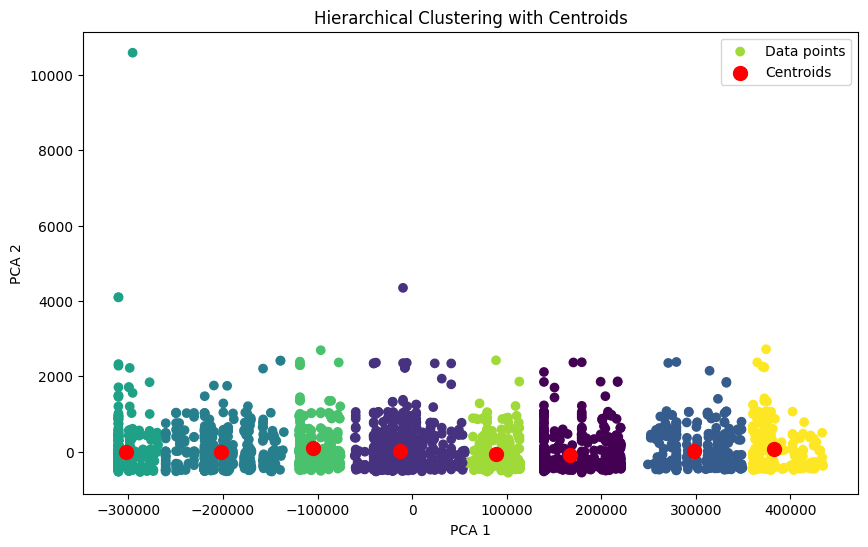

In [21]:
# Calculate centroids
centroids = df.groupby('cluster').mean()

# For visualization: Reduce dimensions (if necessary)
pca = PCA(n_components=2)  # Adjust n_components as needed
df_pca = pca.fit_transform(df.drop('cluster', axis=1))
centroids_pca = pca.transform(centroids)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=hc_clusters, cmap='viridis', label='Data points')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, c='red', label='Centroids')
plt.title('Hierarchical Clustering with Centroids')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

Gaussian-mixture odredjivanje n-components

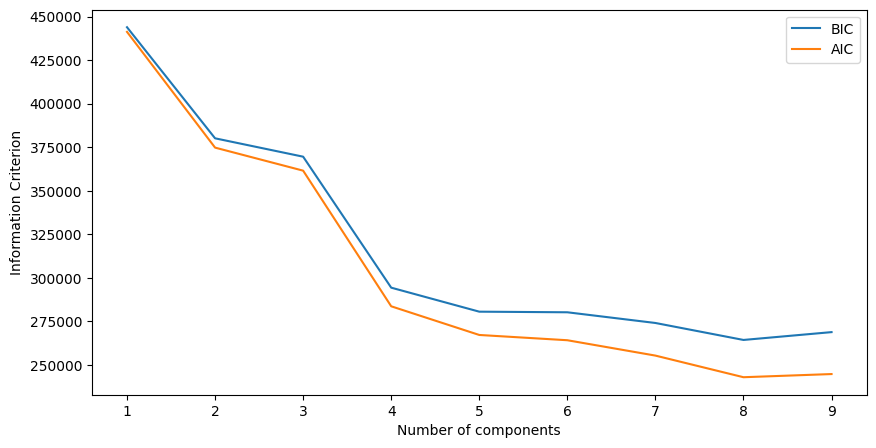

In [22]:
n_components = np.arange(1, 10)  # Range of potential cluster numbers
bics = []
aics = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(df)
    bics.append(gmm.bic(df))
    aics.append(gmm.aic(df))

plt.figure(figsize=(10, 5))
plt.plot(n_components, bics, label='BIC')
plt.plot(n_components, aics, label='AIC')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.legend()
plt.show()

Gaussian-mixture klasterizacija

In [2]:
# Gaussian Mixture Models
n_clusters_gmm = int(input("Enter the number of clusters for GMM: "))
gmm = GaussianMixture(n_components=n_clusters_gmm, random_state=0)
gmm_clusters = gmm.fit_predict(df)

df['cluster'] = gmm_clusters
df.to_csv('books_clustered-gmm.csv', index=False)

silhouette_avg_gmm = silhouette_score(df, gmm_clusters)
print("Silhouette Score for GMM: ", silhouette_avg_gmm)

Silhouette Score for GMM:  -0.5745570348090381


Odredjivanje i vizuelizacija centroida za Gaussian-mixture model

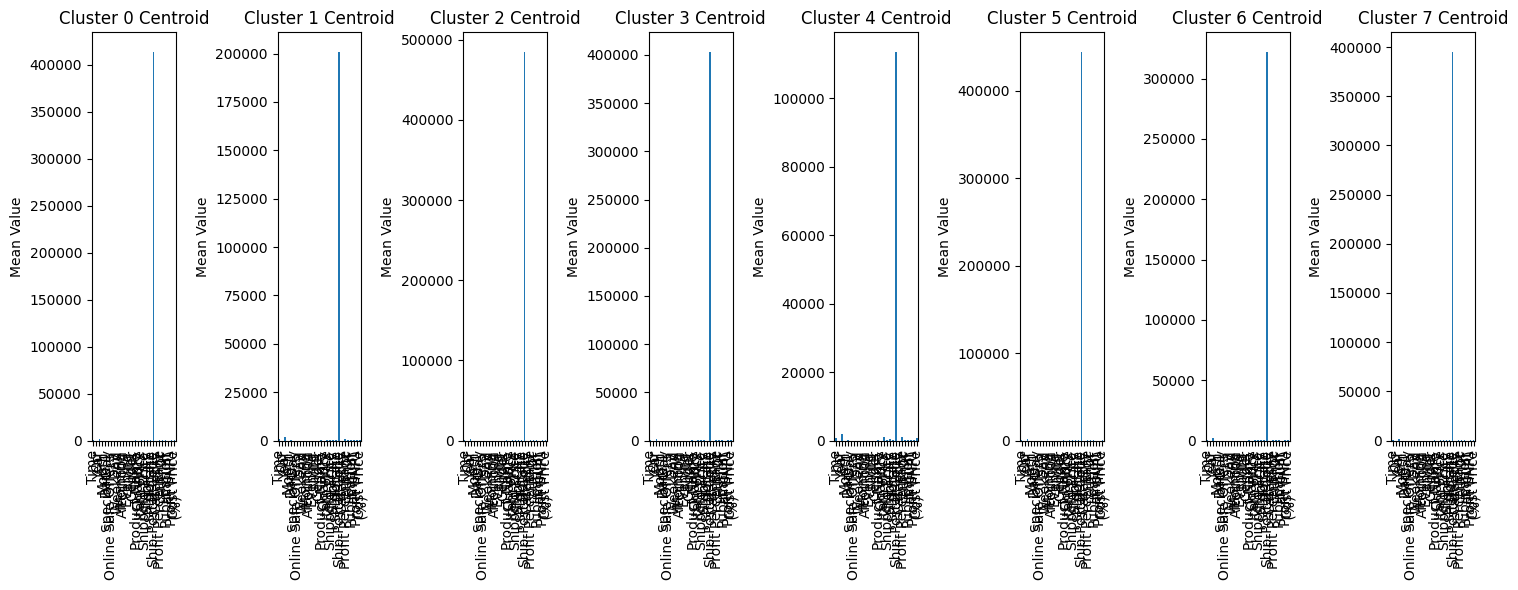

In [1]:
# Analyzing centroids
gmm_centroids = gmm.means_

# Visualizing centroids
centroids_df = pd.DataFrame(gmm_centroids, columns=df.columns)
plt.figure(figsize=(15, 6))
for i in range(centroids_df.shape[0]):
    plt.subplot(1, centroids_df.shape[0], i+1)
    centroids_df.iloc[i].plot(kind='bar')
    plt.title(f'Cluster {i} Centroid')
    plt.ylabel('Mean Value')
plt.tight_layout()
plt.show()